In [1]:
!pip install gymnasium
!pip install "stable_baselines3[extra]>=2.0.0a9"

from google.colab import files,drive
import sys
import pandas as pd
import numpy as np
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Thesis/Code')
path='/content/drive/MyDrive/Thesis/Data Folder/Sorted_SKU.csv'
sorted=pd.read_csv(path)
sorted=sorted.set_axis(['SKU'], axis=1)

import data
import market_gym

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import os
from stable_baselines3.common import results_plotter
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import ProgressBarCallback

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.0 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=6d50b8593c1cce6913449ace1e6e216e1ccf5ecb551de81090e35d2f51492474
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.0
    Uninstalling gymnasium-0.29.0:
      Successfully uninstalled gymnasium-0.29.0
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [2]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Output()

Reward per episode 493.1550000000001±27.728012640649155


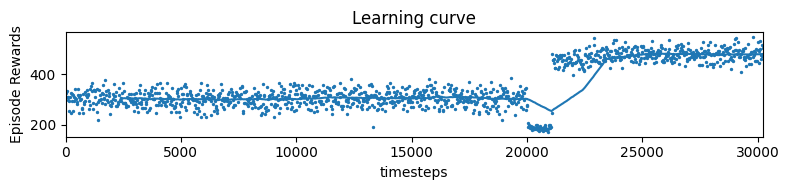

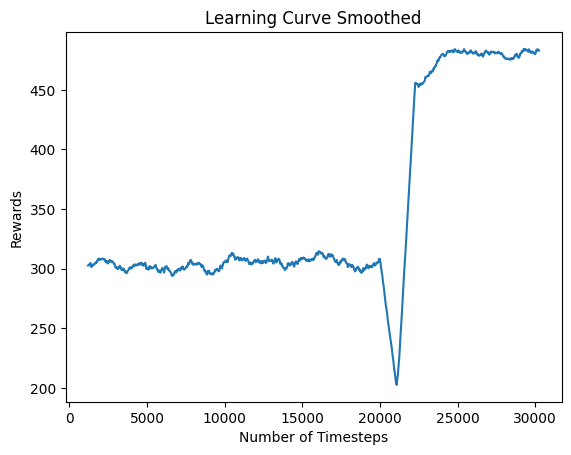

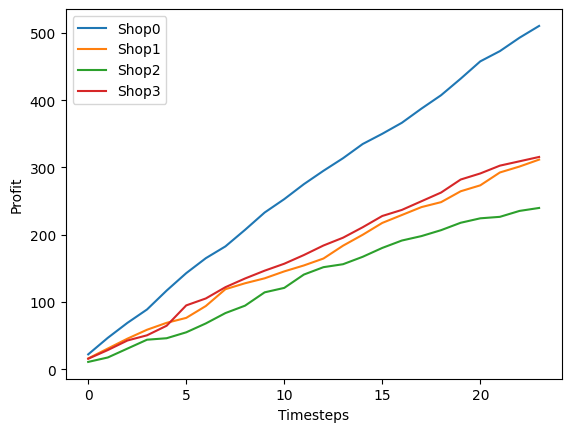

Output()

Reward per episode 452.08500000000004±27.40728197030855


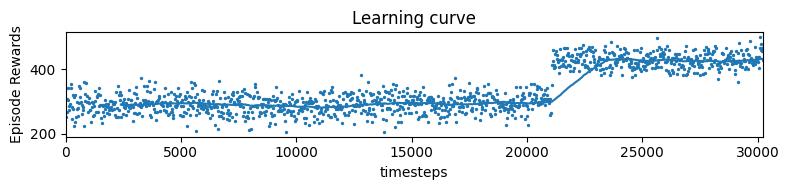

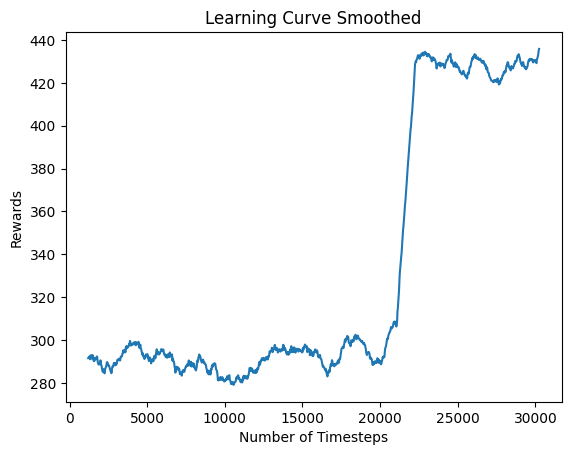

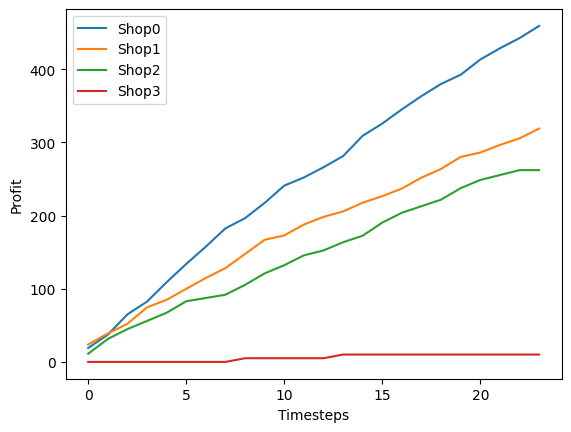

Output()

Reward per episode 517.088±9.524348586648866


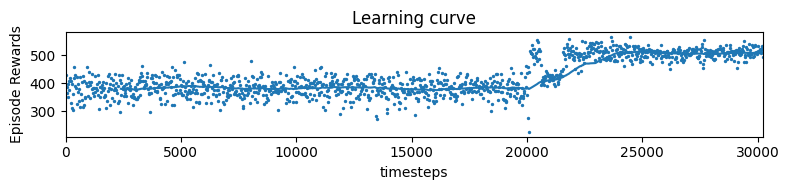

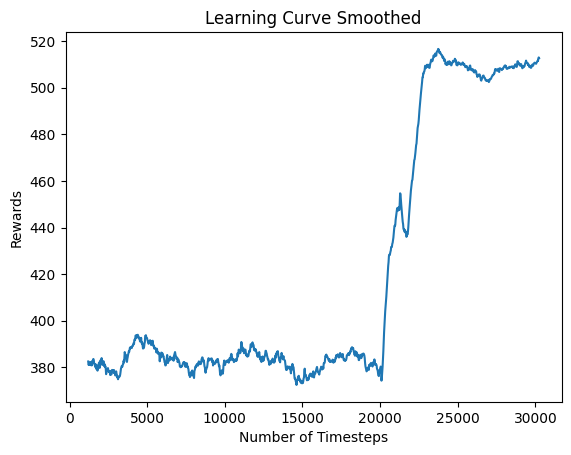

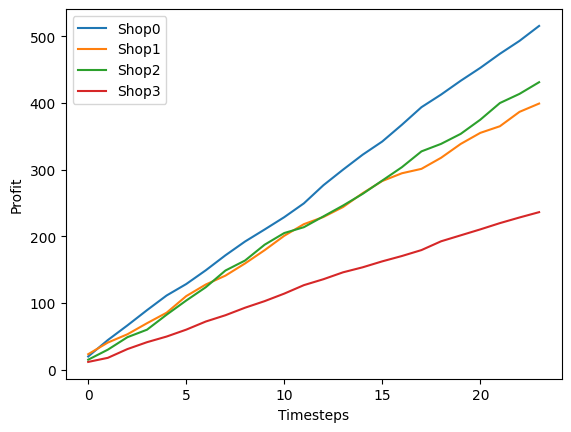

Output()

Reward per episode 694.4399999999999±18.042350179508215


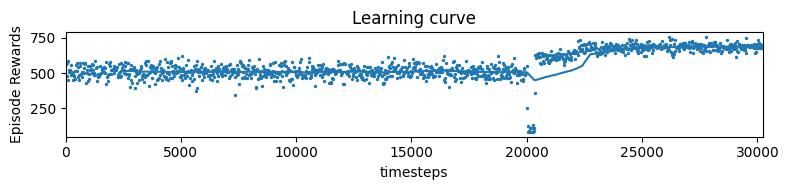

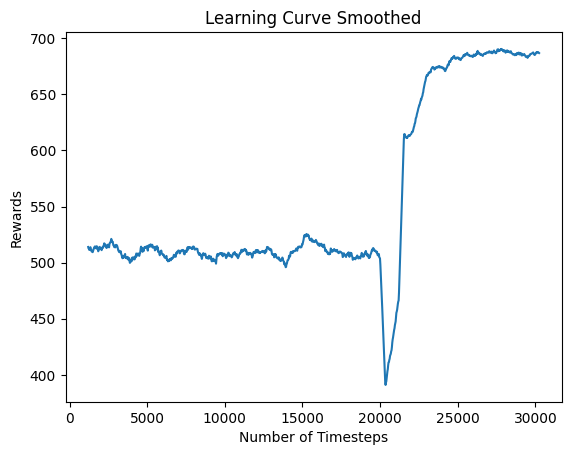

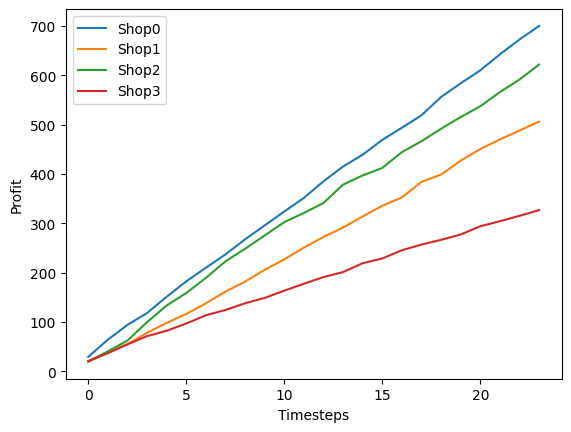

Output()

Reward per episode 798.064±33.28747608335604


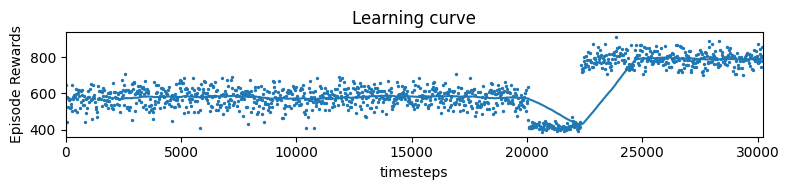

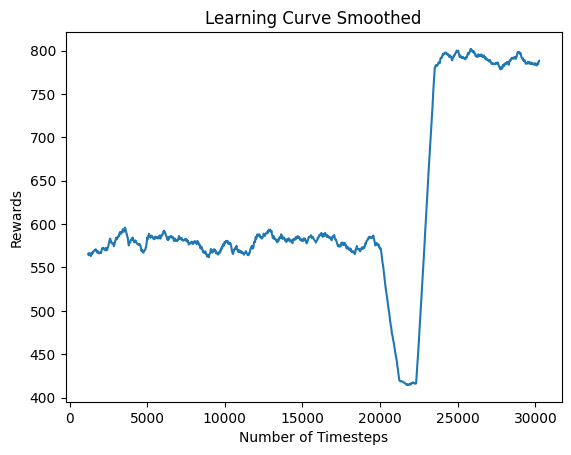

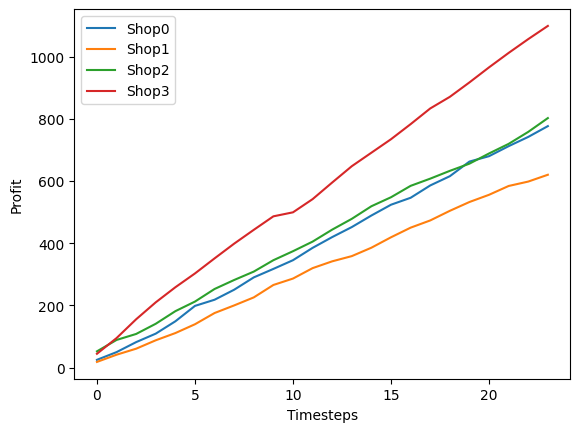

Output()

Reward per episode 112.2±3.6389888705518176


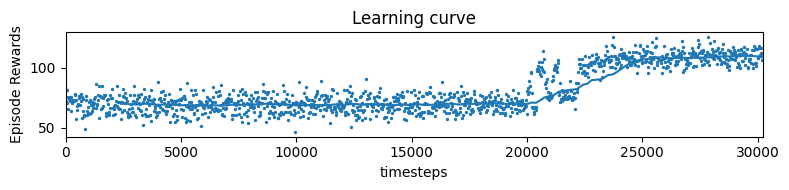

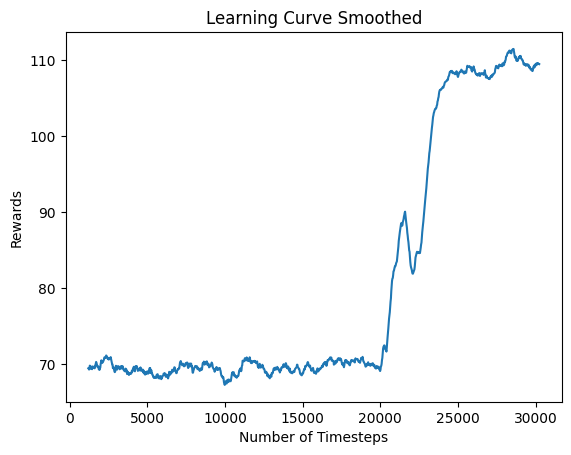

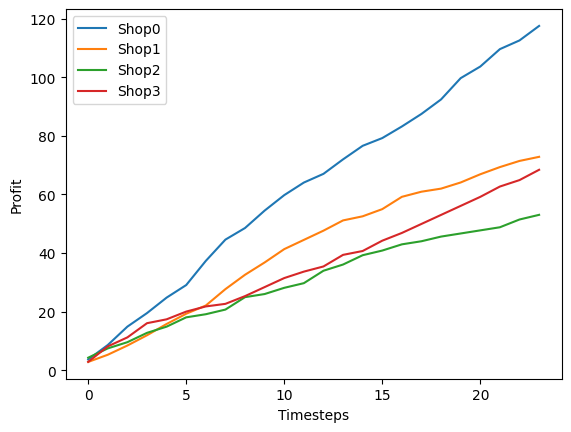

Output()

Reward per episode 757.5469999999999±43.54568797251917


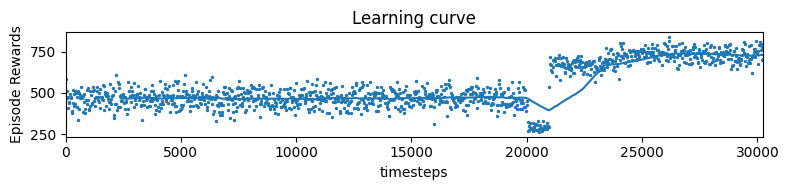

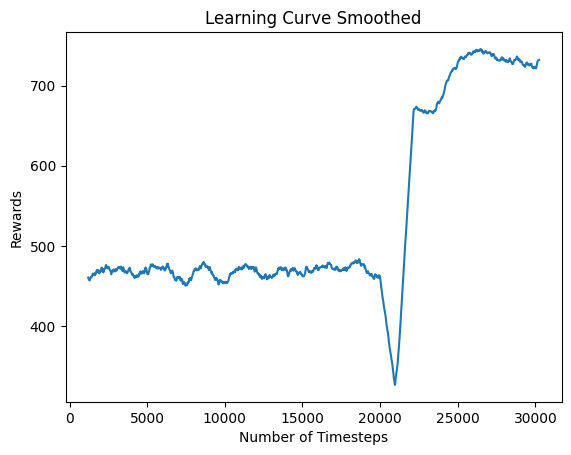

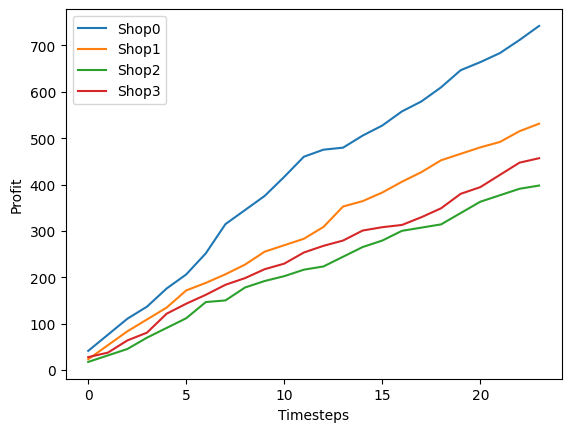

Output()

Reward per episode 331.93600000000004±13.929384193136467


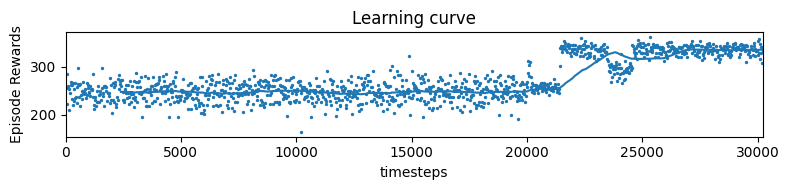

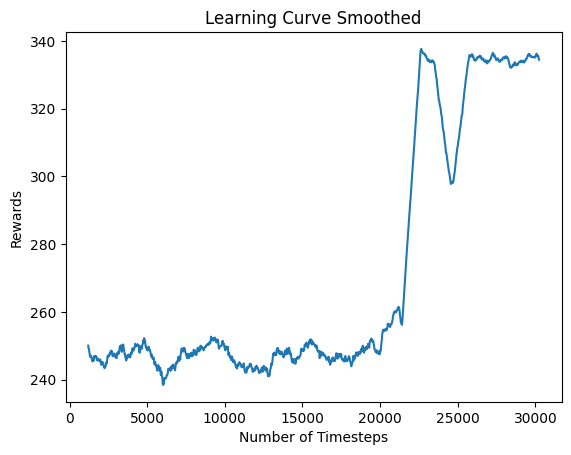

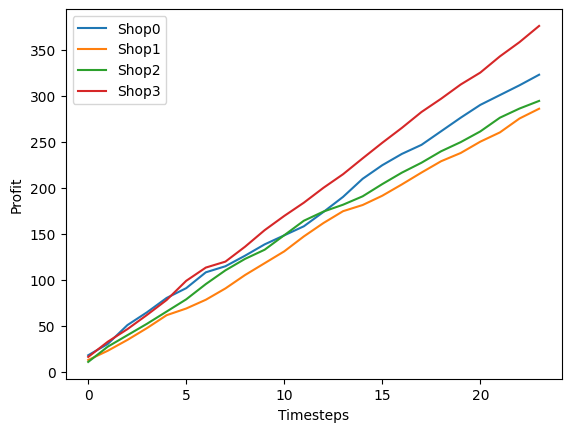

Output()

Reward per episode 169.45200000000003±6.156000000000005


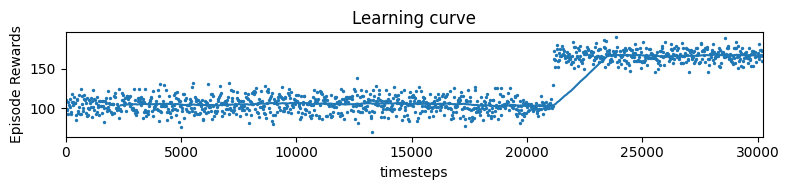

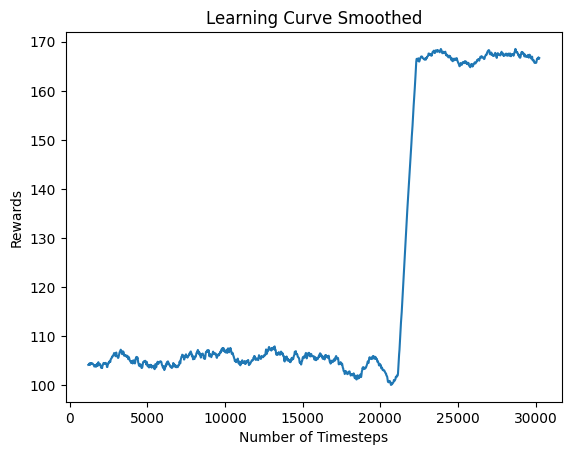

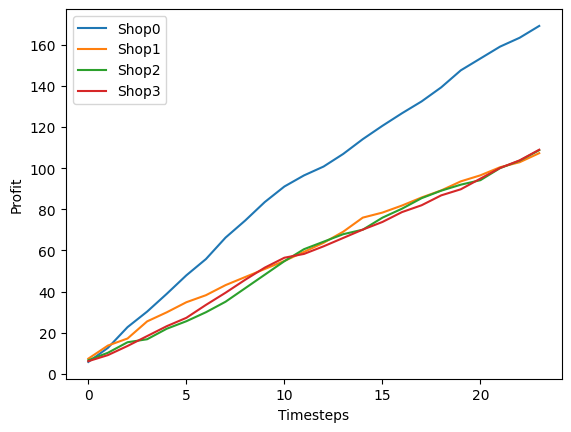

Output()

Reward per episode 400.574±9.355063014218558


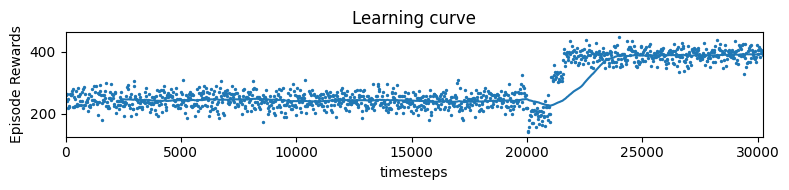

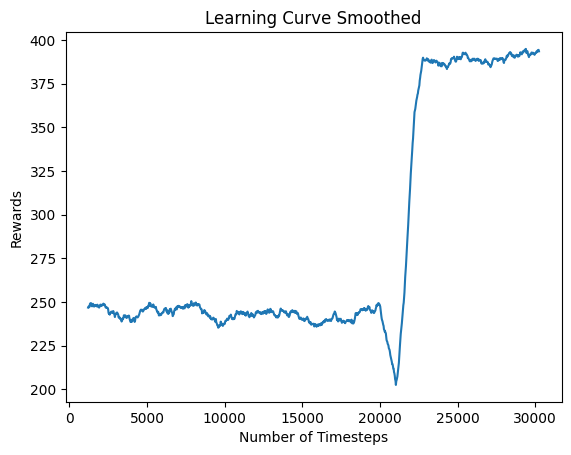

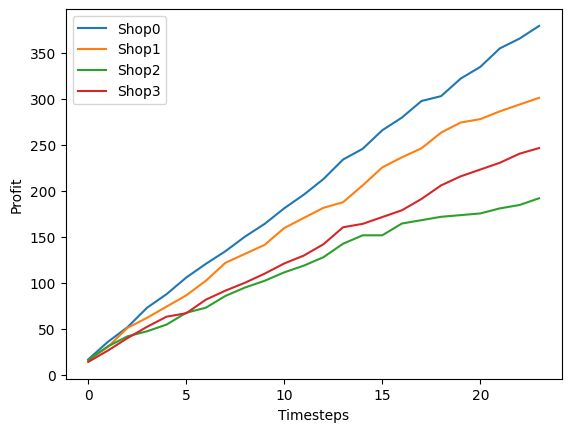

Output()

Reward per episode 766.314±18.117460749233032


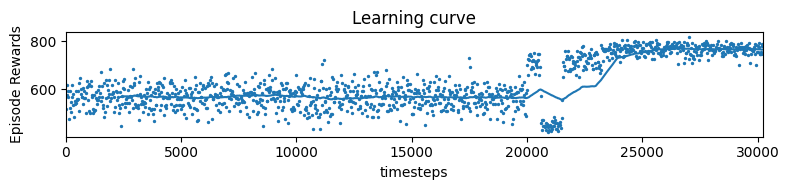

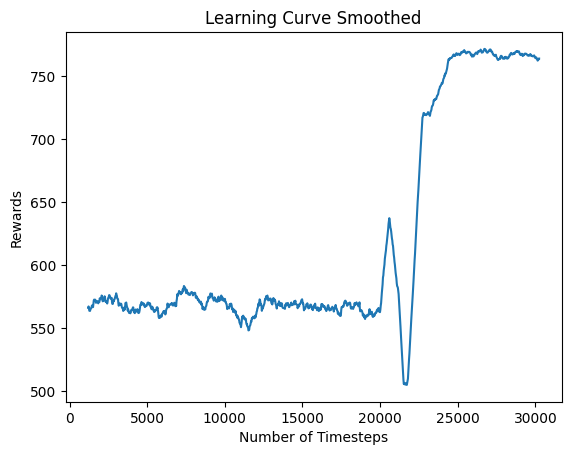

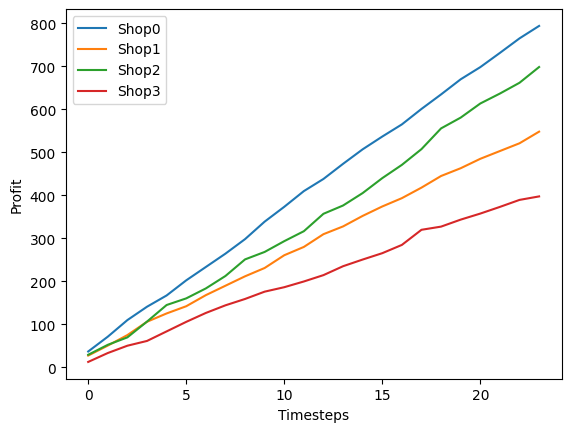

Output()

Reward per episode 214.272±8.738261612014144


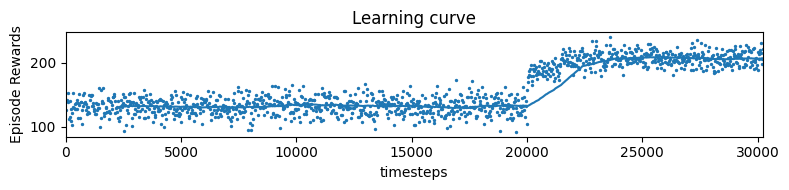

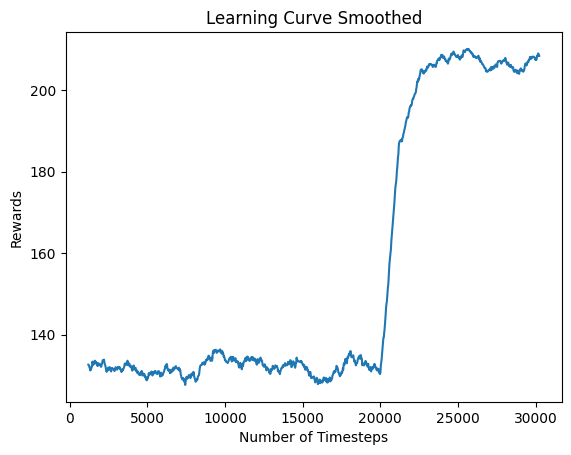

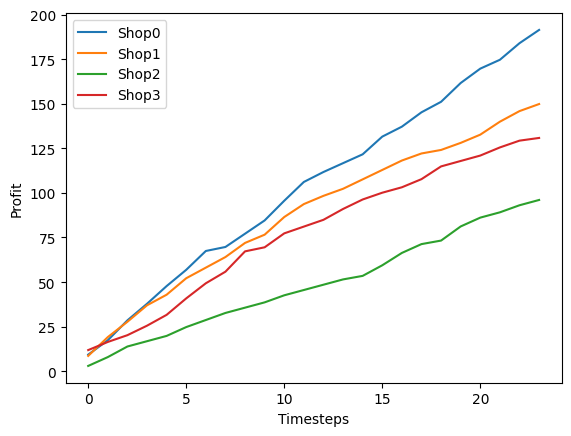

Output()

Reward per episode 194.25±5.189653167601858


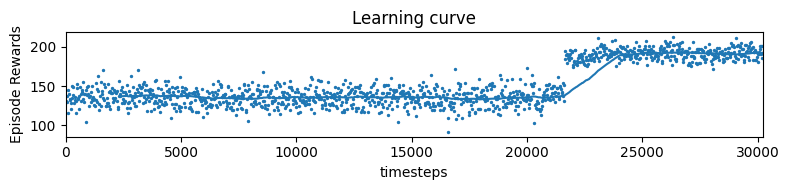

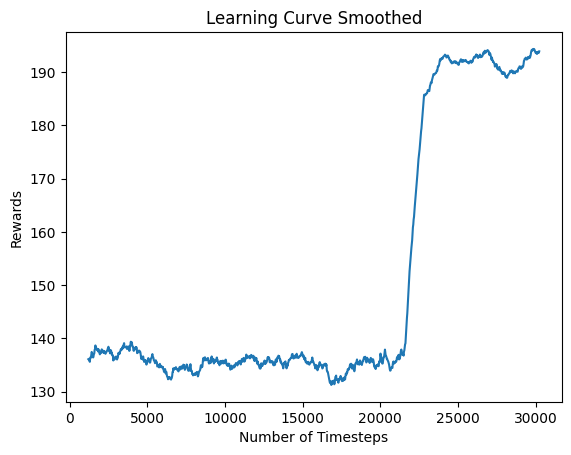

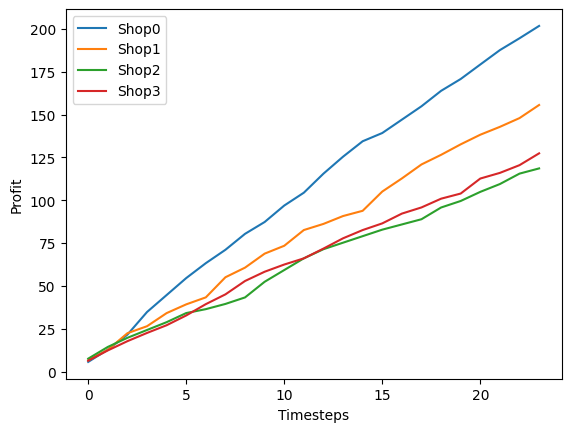

Output()

In [ ]:
profits=pd.DataFrame(columns=['Shop0','Shop1','Shop2','Shop3'])
for i in sorted.SKU[33:100]:
  #load data
  df=data.item(i)
  #create marketenvironment
  env = market_gym.CustomEnv(df,5000)
  # Create log dir
  log_dir = "/tmp/gym/"
  os.makedirs(log_dir, exist_ok=True)
  env = Monitor(env, log_dir)
  #del model
  model = DQN("MlpPolicy", env, verbose=0,batch_size=128,learning_rate=0.0001, learning_starts=20000, policy_kwargs={'net_arch': [128,64,32,16]})
  model.learn(total_timesteps=30000, progress_bar=True)
  #print mean reward of 10 episodes
  mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
  print(f'Reward per episode {mean_reward}±{std_reward}')
  #plot training reward
  results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS,'Learning curve')
  plot_results(log_dir)
  model.save('/content/drive/MyDrive/Thesis/Code/Models/'+'Model1_'+str(i))
  #simulation
  #model=DQN.load('/content/drive/MyDrive/Thesis/Code/Models/'+'Model_'+str(i))
  episodes = 1
  for episode in range(1, episodes+1):
    obs,_states= env.reset()
    terminated=False
    while not terminated:
          action, _states = model.predict(obs)
          obs, reward, terminated,turnicated, info = env.step(action)
          #env.render()
          new_row={'Shop0':(info['p0']-info['cost'])*info['s0'],'Shop1':(info['p1']-info['cost'])*info['s1'],'Shop2':(info['p2']-info['cost'])*info['s2'],'Shop3':(info['p3']-info['cost'])*info['s3']}
          profits=pd.concat([profits, pd.DataFrame([new_row])], ignore_index=True)
          #print('obs=', obs,' info=',info ,'  reward=', reward)
    ax=profits.cumsum().plot()
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("Profit")
    plt.show()
    profits=profits[0:0]
  del model

In [ ]:
del model

In [ ]:
profits=pd.DataFrame(columns=['Shop0','Shop1','Shop2','Shop3'])
for i in sorted.SKU[32:33]:
  df=data.item(i)
  print(i)
  model=DQN.load('/content/drive/MyDrive/Thesis/Code/Models/'+'Model_'+str(i))
  env = market_gym.CustomEnv(df,5000)
  episodes = 1
  for episode in range(1, episodes+1):
    obs,_states= env.reset()
    terminated=False
    while not terminated:
          action, _states = model.predict(obs)
          obs, reward, terminated,turnicated, info = env.step(action)
          #env.render()
          new_row={'Shop0':(info['p0']-info['cost'])*info['s0'],'Shop1':(info['p1']-info['cost'])*info['s1'],'Shop2':(info['p2']-info['cost'])*info['s2'],'Shop3':(info['p3']-info['cost'])*info['s3']}
          profits=pd.concat([profits, pd.DataFrame([new_row])], ignore_index=True)
          print('obs=', obs,' info=',info ,'  reward=', reward)
    ax=profits.cumsum().plot()
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("Profit")
    plt.show()
    profits.append(profits.mean())
  del model

861928
obs= [26.54 27.75 25.67]  info= {'cost': 24.13, 'p0': 28.8, 'p1': 26.54, 'p2': 27.75, 'p3': 25.67, 's0': 14, 's1': 18, 's2': 30, 's3': 50}   reward= 65.38000000000002
obs= [26.54 27.75 26.03]  info= {'cost': 24.13, 'p0': 28.8, 'p1': 26.54, 'p2': 27.75, 'p3': 26.03, 's0': 14, 's1': 23, 's2': 21, 's3': 46}   reward= 65.38000000000002
obs= [26.54 27.75 26.03]  info= {'cost': 24.13, 'p0': 28.8, 'p1': 26.54, 'p2': 27.75, 'p3': 26.03, 's0': 12, 's1': 22, 's2': 19, 's3': 49}   reward= 56.04000000000002
obs= [26.54 27.75 26.03]  info= {'cost': 24.13, 'p0': 28.8, 'p1': 26.54, 'p2': 27.75, 'p3': 26.03, 's0': 11, 's1': 23, 's2': 16, 's3': 49}   reward= 51.37000000000002
obs= [26.54 27.75 26.03]  info= {'cost': 24.13, 'p0': 28.8, 'p1': 26.54, 'p2': 27.75, 'p3': 26.03, 's0': 10, 's1': 23, 's2': 16, 's3': 56}   reward= 46.70000000000002
obs= [26.54 27.75 26.03]  info= {'cost': 24.13, 'p0': 28.8, 'p1': 26.54, 'p2': 27.75, 'p3': 26.03, 's0': 11, 's1': 24, 's2': 15, 's3': 45}   reward= 51.370000

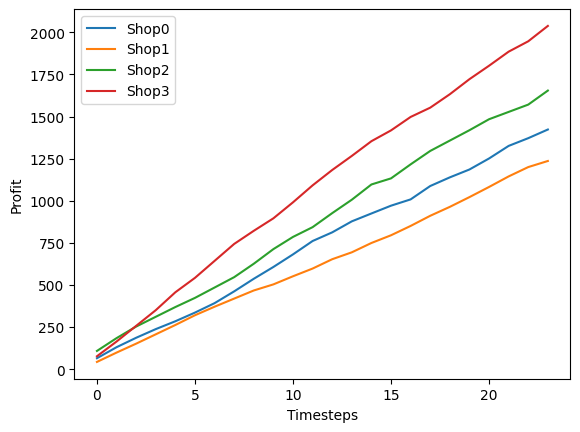

878409
obs= [16.08 16.81 15.72]  info= {'cost': 14.62, 'p0': 15.69, 'p1': 16.08, 'p2': 16.81, 'p3': 15.72, 's0': 30, 's1': 10, 's2': 9, 's3': 10}   reward= 32.10000000000001
obs= [16.08 16.81 15.71]  info= {'cost': 14.62, 'p0': 15.69, 'p1': 16.08, 'p2': 16.81, 'p3': 15.71, 's0': 22, 's1': 9, 's2': 10, 's3': 14}   reward= 23.540000000000006
obs= [16.08 16.81 15.71]  info= {'cost': 14.62, 'p0': 15.69, 'p1': 16.08, 'p2': 16.81, 'p3': 15.71, 's0': 23, 's1': 13, 's2': 10, 's3': 15}   reward= 24.610000000000007
obs= [16.08 16.81 15.71]  info= {'cost': 14.62, 'p0': 15.69, 'p1': 16.08, 'p2': 16.81, 'p3': 15.71, 's0': 31, 's1': 10, 's2': 4, 's3': 15}   reward= 33.17000000000001
obs= [16.08 16.81 15.71]  info= {'cost': 14.62, 'p0': 15.69, 'p1': 16.08, 'p2': 16.81, 'p3': 15.71, 's0': 24, 's1': 8, 's2': 11, 's3': 8}   reward= 25.680000000000007
obs= [16.08 16.81 15.71]  info= {'cost': 14.62, 'p0': 15.69, 'p1': 16.08, 'p2': 16.81, 'p3': 15.71, 's0': 16, 's1': 14, 's2': 6, 's3': 21}   reward= 17.120

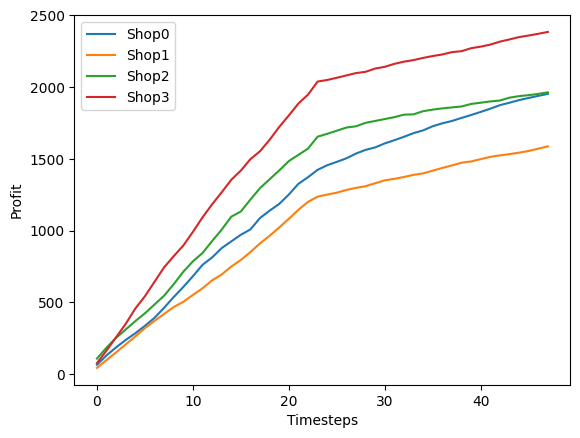

912646
obs= [13.88 14.51 13.43]  info= {'cost': 12.62, 'p0': 13.29, 'p1': 13.88, 'p2': 14.51, 'p3': 13.43, 's0': 48, 's1': 19, 's2': 18, 's3': 20}   reward= 32.16
obs= [13.88 14.51 13.34]  info= {'cost': 12.62, 'p0': 13.29, 'p1': 13.88, 'p2': 14.51, 'p3': 13.34, 's0': 39, 's1': 24, 's2': 15, 's3': 25}   reward= 26.129999999999995
obs= [13.88 14.51 13.34]  info= {'cost': 12.62, 'p0': 13.29, 'p1': 13.88, 'p2': 14.51, 'p3': 13.34, 's0': 46, 's1': 19, 's2': 10, 's3': 24}   reward= 30.819999999999997
obs= [13.88 14.51 13.34]  info= {'cost': 12.62, 'p0': 13.29, 'p1': 13.88, 'p2': 14.51, 'p3': 13.34, 's0': 40, 's1': 21, 's2': 15, 's3': 28}   reward= 26.799999999999997
obs= [13.88 14.51 13.34]  info= {'cost': 12.62, 'p0': 13.29, 'p1': 13.88, 'p2': 14.51, 'p3': 13.34, 's0': 47, 's1': 20, 's2': 12, 's3': 24}   reward= 31.489999999999995
obs= [13.88 14.51 13.34]  info= {'cost': 12.62, 'p0': 13.29, 'p1': 13.88, 'p2': 14.51, 'p3': 13.34, 's0': 52, 's1': 21, 's2': 12, 's3': 18}   reward= 34.83999999

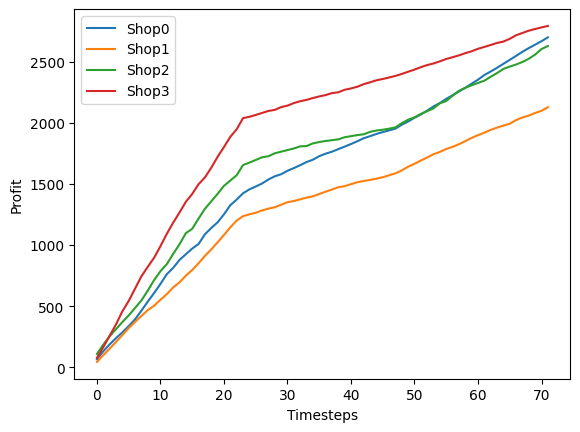

818497
obs= [17.95 18.77 17.36]  info= {'cost': 16.32, 'p0': 17.19, 'p1': 17.95, 'p2': 18.77, 'p3': 17.36, 's0': 44, 's1': 18, 's2': 15, 's3': 21}   reward= 38.280000000000044
obs= [17.95 18.77 17.25]  info= {'cost': 16.32, 'p0': 17.19, 'p1': 17.95, 'p2': 18.77, 'p3': 17.25, 's0': 48, 's1': 16, 's2': 12, 's3': 31}   reward= 41.76000000000005
obs= [17.95 18.77 17.25]  info= {'cost': 16.32, 'p0': 17.19, 'p1': 17.95, 'p2': 18.77, 'p3': 17.25, 's0': 52, 's1': 22, 's2': 9, 's3': 22}   reward= 45.24000000000005
obs= [17.95 18.77 17.25]  info= {'cost': 16.32, 'p0': 17.19, 'p1': 17.95, 'p2': 18.77, 'p3': 17.25, 's0': 43, 's1': 19, 's2': 18, 's3': 20}   reward= 37.41000000000004
obs= [17.95 18.77 17.25]  info= {'cost': 16.32, 'p0': 17.19, 'p1': 17.95, 'p2': 18.77, 'p3': 17.25, 's0': 42, 's1': 18, 's2': 13, 's3': 24}   reward= 36.54000000000004
obs= [17.95 18.77 17.25]  info= {'cost': 16.32, 'p0': 17.19, 'p1': 17.95, 'p2': 18.77, 'p3': 17.25, 's0': 49, 's1': 16, 's2': 20, 's3': 15}   reward= 42.

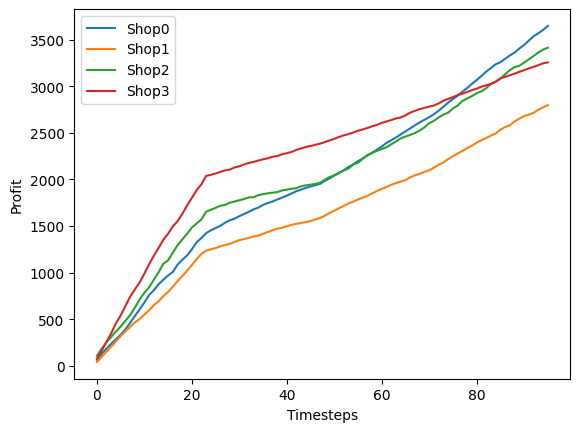

836314
obs= [10.48 10.96 10.57]  info= {'cost': 9.53, 'p0': 10.36, 'p1': 10.48, 'p2': 10.96, 'p3': 10.57, 's0': 24, 's1': 8, 's2': 5, 's3': 5}   reward= 19.92
obs= [10.48 10.96 10.49]  info= {'cost': 9.53, 'p0': 10.36, 'p1': 10.48, 'p2': 10.96, 'p3': 10.49, 's0': 13, 's1': 10, 's2': 6, 's3': 9}   reward= 10.790000000000001
obs= [10.48 10.96 10.49]  info= {'cost': 9.53, 'p0': 10.36, 'p1': 10.48, 'p2': 10.96, 'p3': 10.49, 's0': 14, 's1': 10, 's2': 4, 's3': 6}   reward= 11.620000000000001
obs= [10.48 10.96 10.49]  info= {'cost': 9.53, 'p0': 10.36, 'p1': 10.48, 'p2': 10.96, 'p3': 10.49, 's0': 18, 's1': 15, 's2': 6, 's3': 9}   reward= 14.940000000000001
obs= [10.48 10.96 10.49]  info= {'cost': 9.53, 'p0': 10.36, 'p1': 10.48, 'p2': 10.96, 'p3': 10.49, 's0': 17, 's1': 10, 's2': 4, 's3': 7}   reward= 14.110000000000001
obs= [10.48 10.96 10.49]  info= {'cost': 9.53, 'p0': 10.36, 'p1': 10.48, 'p2': 10.96, 'p3': 10.49, 's0': 18, 's1': 13, 's2': 6, 's3': 6}   reward= 14.940000000000001
obs= [10.48

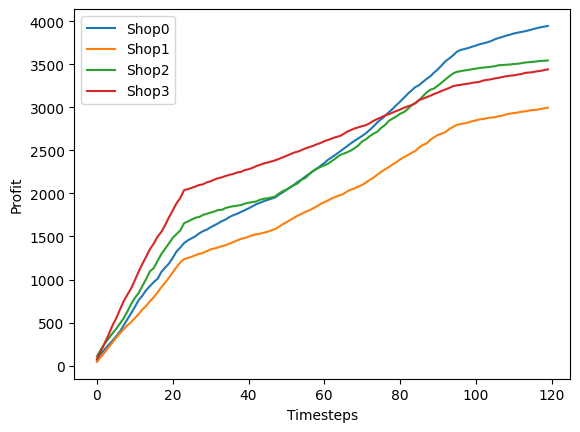

9191485411
obs= [0.46 0.48 0.46]  info= {'cost': 0.42, 'p0': 0.45, 'p1': 0.46, 'p2': 0.48, 'p3': 0.46, 's0': 20, 's1': 11, 's2': 5, 's3': 10}   reward= 0.6000000000000005
obs= [0.46 0.48 0.46]  info= {'cost': 0.42, 'p0': 0.45, 'p1': 0.46, 'p2': 0.48, 'p3': 0.46, 's0': 20, 's1': 11, 's2': 7, 's3': 8}   reward= 0.6000000000000005
obs= [0.46 0.48 0.46]  info= {'cost': 0.42, 'p0': 0.45, 'p1': 0.46, 'p2': 0.48, 'p3': 0.46, 's0': 17, 's1': 11, 's2': 14, 's3': 6}   reward= 0.5100000000000005
obs= [0.46 0.48 0.46]  info= {'cost': 0.42, 'p0': 0.45, 'p1': 0.46, 'p2': 0.48, 'p3': 0.46, 's0': 20, 's1': 13, 's2': 3, 's3': 14}   reward= 0.6000000000000005
obs= [0.46 0.48 0.46]  info= {'cost': 0.42, 'p0': 0.45, 'p1': 0.46, 'p2': 0.48, 'p3': 0.46, 's0': 28, 's1': 4, 's2': 7, 's3': 12}   reward= 0.8400000000000007
obs= [0.46 0.48 0.46]  info= {'cost': 0.42, 'p0': 0.45, 'p1': 0.46, 'p2': 0.48, 'p3': 0.46, 's0': 19, 's1': 12, 's2': 7, 's3': 6}   reward= 0.5700000000000005
obs= [0.46 0.48 0.46]  info= {'c

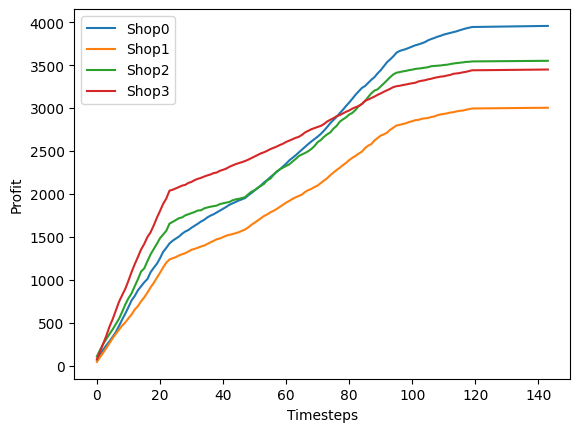

871340
obs= [1.96 2.05 1.89]  info= {'cost': 1.78, 'p0': 2.04, 'p1': 1.96, 'p2': 2.05, 'p3': 1.89, 's0': 15, 's1': 29, 's2': 16, 's3': 48}   reward= 3.9000000000000004
obs= [1.96 2.05 1.9 ]  info= {'cost': 1.78, 'p0': 2.04, 'p1': 1.96, 'p2': 2.05, 'p3': 1.9, 's0': 19, 's1': 20, 's2': 16, 's3': 46}   reward= 4.94
obs= [1.96 2.05 1.9 ]  info= {'cost': 1.78, 'p0': 2.04, 'p1': 1.96, 'p2': 2.05, 'p3': 1.9, 's0': 11, 's1': 24, 's2': 14, 's3': 52}   reward= 2.8600000000000003
obs= [1.96 2.05 1.9 ]  info= {'cost': 1.78, 'p0': 2.04, 'p1': 1.96, 'p2': 2.05, 'p3': 1.9, 's0': 19, 's1': 22, 's2': 8, 's3': 49}   reward= 4.94
obs= [1.96 2.05 1.9 ]  info= {'cost': 1.78, 'p0': 2.04, 'p1': 1.96, 'p2': 2.05, 'p3': 1.9, 's0': 17, 's1': 15, 's2': 20, 's3': 45}   reward= 4.42
obs= [1.96 2.05 1.9 ]  info= {'cost': 1.78, 'p0': 2.04, 'p1': 1.96, 'p2': 2.05, 'p3': 1.9, 's0': 18, 's1': 23, 's2': 22, 's3': 40}   reward= 4.68
obs= [1.96 2.05 1.9 ]  info= {'cost': 1.78, 'p0': 2.04, 'p1': 1.96, 'p2': 2.05, 'p3': 1.9

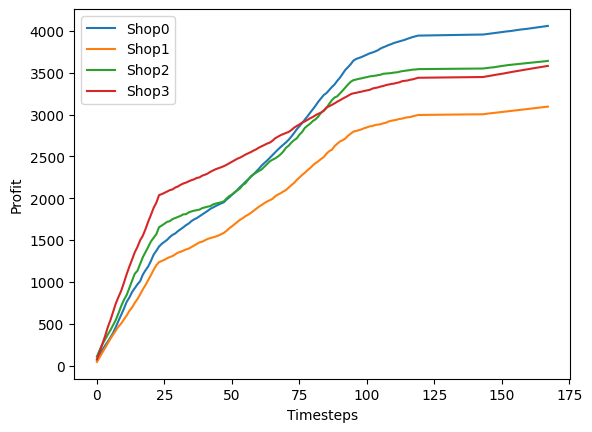

867911
obs= [21.1  22.06 20.41]  info= {'cost': 19.18, 'p0': 22.89, 'p1': 21.1, 'p2': 22.06, 'p3': 20.41, 's0': 13, 's1': 24, 's2': 13, 's3': 56}   reward= 48.23000000000001
obs= [21.1  22.06 20.7 ]  info= {'cost': 19.18, 'p0': 22.89, 'p1': 21.1, 'p2': 22.06, 'p3': 20.7, 's0': 15, 's1': 18, 's2': 20, 's3': 49}   reward= 55.65000000000001
obs= [21.1  22.06 20.7 ]  info= {'cost': 19.18, 'p0': 22.89, 'p1': 21.1, 'p2': 22.06, 'p3': 20.7, 's0': 12, 's1': 24, 's2': 20, 's3': 45}   reward= 44.52000000000001
obs= [21.1  22.06 20.7 ]  info= {'cost': 19.18, 'p0': 22.89, 'p1': 21.1, 'p2': 22.06, 'p3': 20.7, 's0': 17, 's1': 19, 's2': 12, 's3': 55}   reward= 63.070000000000014
obs= [21.1  22.06 20.7 ]  info= {'cost': 19.18, 'p0': 22.89, 'p1': 21.1, 'p2': 22.06, 'p3': 20.7, 's0': 15, 's1': 23, 's2': 19, 's3': 47}   reward= 55.65000000000001
obs= [21.1  22.06 20.7 ]  info= {'cost': 19.18, 'p0': 22.89, 'p1': 21.1, 'p2': 22.06, 'p3': 20.7, 's0': 11, 's1': 19, 's2': 20, 's3': 52}   reward= 40.8100000000

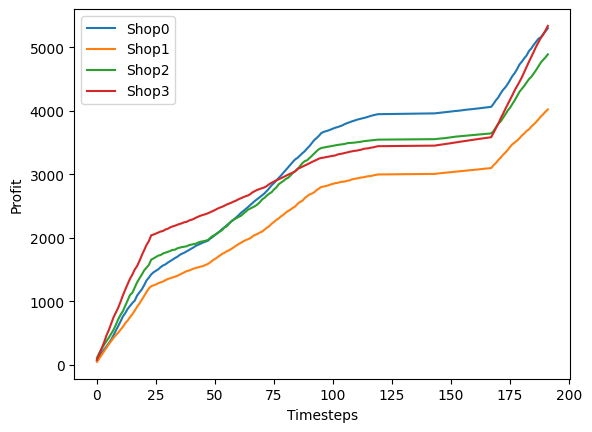

860031
obs= [22.15 23.16 21.43]  info= {'cost': 20.14, 'p0': 24.03, 'p1': 22.15, 'p2': 23.16, 'p3': 21.43, 's0': 8, 's1': 21, 's2': 24, 's3': 50}   reward= 31.120000000000005
obs= [22.15 23.16 21.73]  info= {'cost': 20.14, 'p0': 24.03, 'p1': 22.15, 'p2': 23.16, 'p3': 21.73, 's0': 16, 's1': 28, 's2': 15, 's3': 45}   reward= 62.24000000000001
obs= [22.15 23.16 21.41]  info= {'cost': 20.14, 'p0': 22.29, 'p1': 22.15, 'p2': 23.16, 'p3': 21.41, 's0': 23, 's1': 18, 's2': 17, 's3': 44}   reward= 49.44999999999997
obs= [22.15 23.16 21.73]  info= {'cost': 20.14, 'p0': 24.03, 'p1': 22.15, 'p2': 23.16, 'p3': 21.73, 's0': 13, 's1': 22, 's2': 15, 's3': 51}   reward= 50.57000000000001
obs= [22.15 23.16 21.15]  info= {'cost': 20.14, 'p0': 21.48, 'p1': 22.15, 'p2': 23.16, 'p3': 21.15, 's0': 21, 's1': 17, 's2': 16, 's3': 53}   reward= 28.139999999999997
obs= [22.15 23.16 21.73]  info= {'cost': 20.14, 'p0': 24.03, 'p1': 22.15, 'p2': 23.16, 'p3': 21.73, 's0': 16, 's1': 18, 's2': 26, 's3': 46}   reward= 62

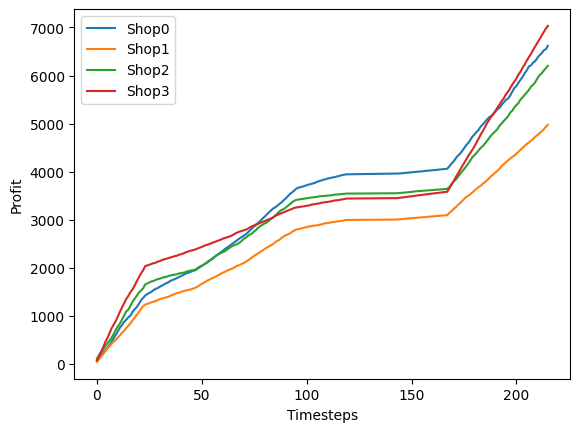

911865
obs= [19.39 20.27 18.76]  info= {'cost': 17.63, 'p0': 18.57, 'p1': 19.39, 'p2': 20.27, 'p3': 18.76, 's0': 39, 's1': 15, 's2': 10, 's3': 15}   reward= 36.66000000000005
obs= [19.39 20.27 18.63]  info= {'cost': 17.63, 'p0': 18.57, 'p1': 19.39, 'p2': 20.27, 'p3': 18.63, 's0': 33, 's1': 14, 's2': 9, 's3': 17}   reward= 31.020000000000042
obs= [19.39 20.27 18.63]  info= {'cost': 17.63, 'p0': 18.57, 'p1': 19.39, 'p2': 20.27, 'p3': 18.63, 's0': 38, 's1': 20, 's2': 6, 's3': 11}   reward= 35.72000000000005
obs= [19.39 20.27 18.63]  info= {'cost': 17.63, 'p0': 18.57, 'p1': 19.39, 'p2': 20.27, 'p3': 18.63, 's0': 39, 's1': 11, 's2': 7, 's3': 22}   reward= 36.66000000000005
obs= [19.39 20.27 18.63]  info= {'cost': 17.63, 'p0': 18.57, 'p1': 19.39, 'p2': 20.27, 'p3': 18.63, 's0': 24, 's1': 16, 's2': 15, 's3': 20}   reward= 22.56000000000003
obs= [19.39 20.27 18.63]  info= {'cost': 17.63, 'p0': 18.57, 'p1': 19.39, 'p2': 20.27, 'p3': 18.63, 's0': 36, 's1': 8, 's2': 6, 's3': 19}   reward= 33.8400

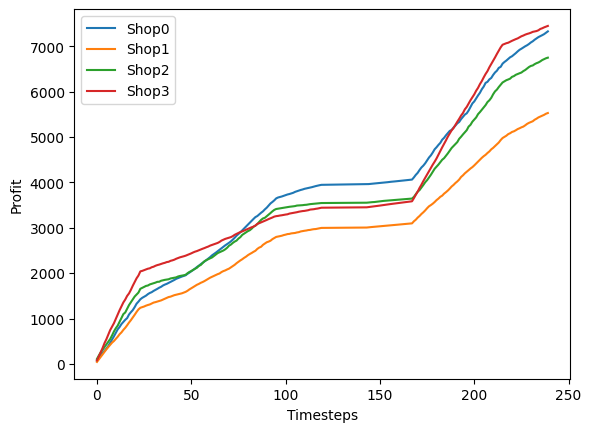

860002
obs= [15.7  16.41 15.34]  info= {'cost': 14.27, 'p0': 15.03, 'p1': 15.7, 'p2': 16.41, 'p3': 15.34, 's0': 32, 's1': 8, 's2': 11, 's3': 15}   reward= 24.319999999999993
obs= [15.7  16.41 15.08]  info= {'cost': 14.27, 'p0': 15.03, 'p1': 15.7, 'p2': 16.41, 'p3': 15.08, 's0': 26, 's1': 7, 's2': 6, 's3': 20}   reward= 19.759999999999994
obs= [15.7  16.41 15.4 ]  info= {'cost': 14.27, 'p0': 17.03, 'p1': 15.7, 'p2': 16.41, 'p3': 15.4, 's0': 7, 's1': 15, 's2': 9, 's3': 19}   reward= 19.32000000000001
obs= [15.7  16.41 15.08]  info= {'cost': 14.27, 'p0': 15.03, 'p1': 15.7, 'p2': 16.41, 'p3': 15.08, 's0': 32, 's1': 5, 's2': 8, 's3': 18}   reward= 24.319999999999993
obs= [15.7  16.41 15.08]  info= {'cost': 14.27, 'p0': 15.03, 'p1': 15.7, 'p2': 16.41, 'p3': 15.08, 's0': 25, 's1': 13, 's2': 7, 's3': 23}   reward= 18.999999999999993
obs= [15.7  16.41 15.08]  info= {'cost': 14.27, 'p0': 15.03, 'p1': 15.7, 'p2': 16.41, 'p3': 15.08, 's0': 33, 's1': 15, 's2': 3, 's3': 18}   reward= 25.079999999999

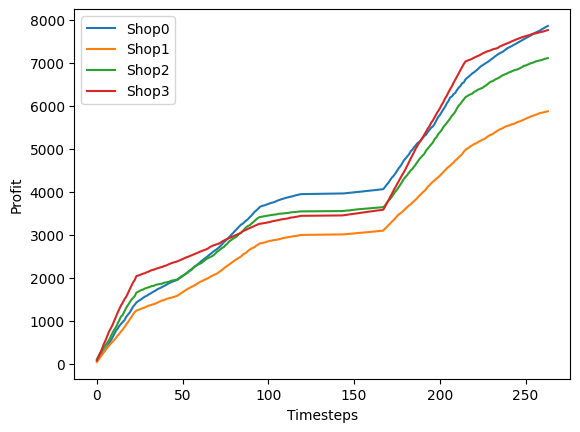

882192
obs= [16.4  17.15 15.86]  info= {'cost': 14.91, 'p0': 15.71, 'p1': 16.4, 'p2': 17.15, 'p3': 15.86, 's0': 43, 's1': 9, 's2': 10, 's3': 25}   reward= 34.400000000000034
obs= [16.4  17.15 15.76]  info= {'cost': 14.91, 'p0': 15.71, 'p1': 16.4, 'p2': 17.15, 'p3': 15.76, 's0': 47, 's1': 6, 's2': 12, 's3': 24}   reward= 37.60000000000004
obs= [16.4  17.15 15.76]  info= {'cost': 14.91, 'p0': 15.71, 'p1': 16.4, 'p2': 17.15, 'p3': 15.76, 's0': 44, 's1': 10, 's2': 8, 's3': 33}   reward= 35.20000000000003
obs= [16.4  17.15 15.76]  info= {'cost': 14.91, 'p0': 15.71, 'p1': 16.4, 'p2': 17.15, 'p3': 15.76, 's0': 43, 's1': 13, 's2': 8, 's3': 21}   reward= 34.400000000000034
obs= [16.4  17.15 15.76]  info= {'cost': 14.91, 'p0': 15.71, 'p1': 16.4, 'p2': 17.15, 'p3': 15.76, 's0': 47, 's1': 11, 's2': 14, 's3': 16}   reward= 37.60000000000004
obs= [16.4  17.15 16.02]  info= {'cost': 14.91, 'p0': 17.59, 'p1': 16.4, 'p2': 17.15, 'p3': 16.02, 's0': 12, 's1': 23, 's2': 19, 's3': 28}   reward= 32.16
obs= 

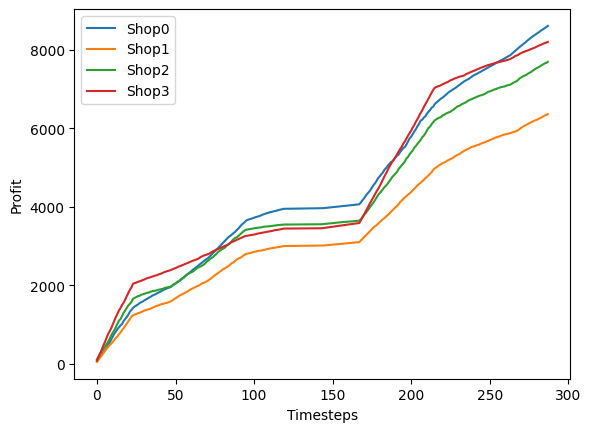

853996
obs= [29.9  31.26 28.92]  info= {'cost': 27.18, 'p0': 28.63, 'p1': 29.9, 'p2': 31.26, 'p3': 28.92, 's0': 50, 's1': 28, 's2': 10, 's3': 18}   reward= 72.49999999999997
obs= [29.9  31.26 28.81]  info= {'cost': 27.18, 'p0': 30.8, 'p1': 29.9, 'p2': 31.26, 'p3': 28.81, 's0': 18, 's1': 19, 's2': 14, 's3': 49}   reward= 65.16000000000003
obs= [29.9  31.26 29.21]  info= {'cost': 27.18, 'p0': 32.07, 'p1': 29.9, 'p2': 31.26, 'p3': 29.21, 's0': 16, 's1': 17, 's2': 19, 's3': 54}   reward= 78.24000000000001
obs= [29.9  31.26 28.73]  info= {'cost': 27.18, 'p0': 28.63, 'p1': 29.9, 'p2': 31.26, 'p3': 28.73, 's0': 49, 's1': 24, 's2': 12, 's3': 22}   reward= 71.04999999999997
obs= [29.9  31.26 28.73]  info= {'cost': 27.18, 'p0': 28.63, 'p1': 29.9, 'p2': 31.26, 'p3': 28.73, 's0': 52, 's1': 20, 's2': 16, 's3': 19}   reward= 75.39999999999996
obs= [29.9  31.26 28.73]  info= {'cost': 27.18, 'p0': 28.63, 'p1': 29.9, 'p2': 31.26, 'p3': 28.73, 's0': 53, 's1': 19, 's2': 10, 's3': 20}   reward= 76.8499999

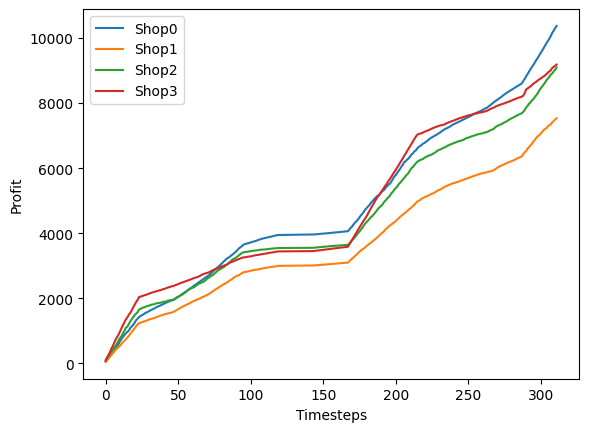

831240
obs= [9.43 9.86 9.12]  info= {'cost': 8.57, 'p0': 10.17, 'p1': 9.43, 'p2': 9.86, 'p3': 9.12, 's0': 15, 's1': 18, 's2': 21, 's3': 51}   reward= 23.999999999999993
obs= [9.43 9.86 9.23]  info= {'cost': 8.57, 'p0': 10.17, 'p1': 9.43, 'p2': 9.86, 'p3': 9.23, 's0': 16, 's1': 22, 's2': 14, 's3': 49}   reward= 25.599999999999994
obs= [9.43 9.86 9.23]  info= {'cost': 8.57, 'p0': 10.17, 'p1': 9.43, 'p2': 9.86, 'p3': 9.23, 's0': 11, 's1': 23, 's2': 24, 's3': 46}   reward= 17.599999999999994
obs= [9.43 9.86 8.98]  info= {'cost': 8.57, 'p0': 9.08, 'p1': 9.43, 'p2': 9.86, 'p3': 8.98, 's0': 25, 's1': 19, 's2': 11, 's3': 53}   reward= 12.749999999999995
obs= [9.43 9.86 9.23]  info= {'cost': 8.57, 'p0': 10.17, 'p1': 9.43, 'p2': 9.86, 'p3': 9.23, 's0': 14, 's1': 19, 's2': 17, 's3': 50}   reward= 22.399999999999995
obs= [9.43 9.86 9.23]  info= {'cost': 8.57, 'p0': 10.17, 'p1': 9.43, 'p2': 9.86, 'p3': 9.23, 's0': 12, 's1': 18, 's2': 20, 's3': 55}   reward= 19.199999999999996
obs= [9.43 9.86 9.23] 

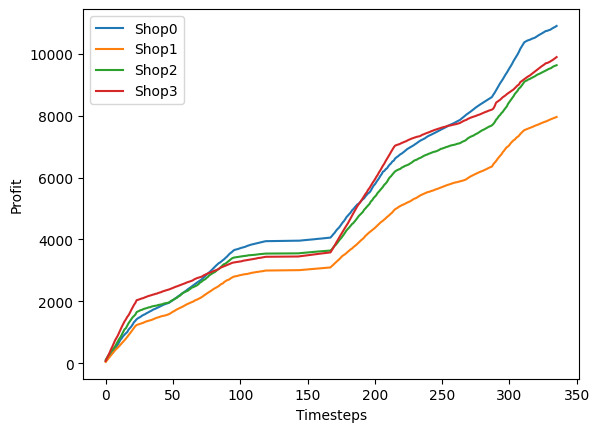

858229
obs= [25.43 26.59 24.6 ]  info= {'cost': 23.12, 'p0': 24.35, 'p1': 25.43, 'p2': 26.59, 'p3': 24.6, 's0': 53, 's1': 27, 's2': 13, 's3': 13}   reward= 65.19000000000003
obs= [25.43 26.59 24.44]  info= {'cost': 23.12, 'p0': 24.35, 'p1': 25.43, 'p2': 26.59, 'p3': 24.44, 's0': 48, 's1': 21, 's2': 19, 's3': 20}   reward= 59.04000000000002
obs= [25.43 26.59 24.44]  info= {'cost': 23.12, 'p0': 24.35, 'p1': 25.43, 'p2': 26.59, 'p3': 24.44, 's0': 46, 's1': 18, 's2': 18, 's3': 24}   reward= 56.58000000000002
obs= [25.43 26.59 24.44]  info= {'cost': 23.12, 'p0': 24.35, 'p1': 25.43, 'p2': 26.59, 'p3': 24.44, 's0': 44, 's1': 21, 's2': 14, 's3': 23}   reward= 54.12000000000002
obs= [25.43 26.59 24.44]  info= {'cost': 23.12, 'p0': 24.35, 'p1': 25.43, 'p2': 26.59, 'p3': 24.44, 's0': 40, 's1': 23, 's2': 16, 's3': 25}   reward= 49.20000000000002
obs= [25.43 26.59 24.44]  info= {'cost': 23.12, 'p0': 24.35, 'p1': 25.43, 'p2': 26.59, 'p3': 24.44, 's0': 52, 's1': 20, 's2': 14, 's3': 17}   reward= 63.9

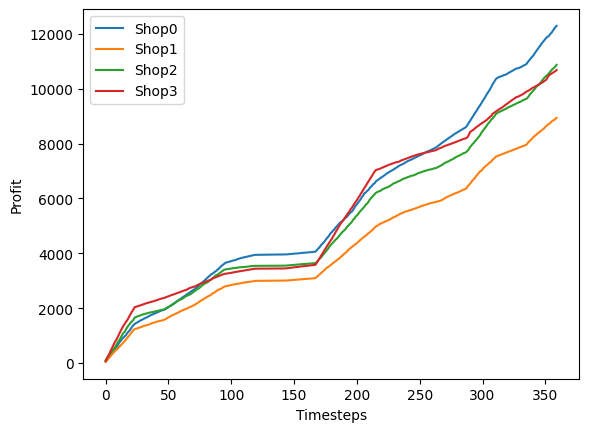

837705
obs= [12.89 13.48 12.47]  info= {'cost': 11.72, 'p0': 12.35, 'p1': 12.89, 'p2': 13.48, 'p3': 12.47, 's0': 46, 's1': 15, 's2': 18, 's3': 22}   reward= 28.979999999999954
obs= [12.89 13.48 12.39]  info= {'cost': 11.72, 'p0': 12.35, 'p1': 12.89, 'p2': 13.48, 'p3': 12.39, 's0': 46, 's1': 21, 's2': 13, 's3': 24}   reward= 28.979999999999954
obs= [12.89 13.48 12.39]  info= {'cost': 11.72, 'p0': 12.35, 'p1': 12.89, 'p2': 13.48, 'p3': 12.39, 's0': 48, 's1': 20, 's2': 11, 's3': 24}   reward= 30.239999999999952
obs= [12.89 13.48 12.39]  info= {'cost': 11.72, 'p0': 12.35, 'p1': 12.89, 'p2': 13.48, 'p3': 12.39, 's0': 49, 's1': 22, 's2': 14, 's3': 21}   reward= 30.86999999999995
obs= [12.89 13.48 12.39]  info= {'cost': 11.72, 'p0': 12.35, 'p1': 12.89, 'p2': 13.48, 'p3': 12.39, 's0': 46, 's1': 19, 's2': 16, 's3': 23}   reward= 28.979999999999954
obs= [12.89 13.48 12.39]  info= {'cost': 11.72, 'p0': 12.35, 'p1': 12.89, 'p2': 13.48, 'p3': 12.39, 's0': 52, 's1': 17, 's2': 15, 's3': 20}   reward=

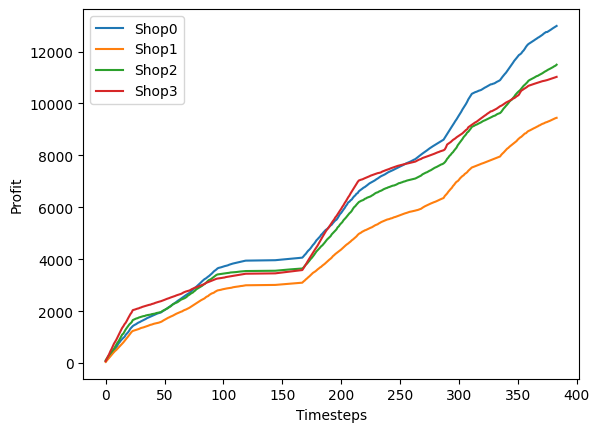

863351
obs= [4.16 4.35 4.02]  info= {'cost': 3.78, 'p0': 4.01, 'p1': 4.16, 'p2': 4.35, 'p3': 4.02, 's0': 35, 's1': 21, 's2': 14, 's3': 22}   reward= 8.049999999999999
obs= [4.16 4.35 4.01]  info= {'cost': 3.78, 'p0': 4.01, 'p1': 4.16, 'p2': 4.35, 'p3': 4.01, 's0': 49, 's1': 16, 's2': 12, 's3': 19}   reward= 11.27
obs= [4.16 4.35 3.96]  info= {'cost': 3.78, 'p0': 3.86, 'p1': 4.16, 'p2': 4.35, 'p3': 3.96, 's0': 47, 's1': 7, 's2': 10, 's3': 29}   reward= 3.7600000000000033
obs= [4.16 4.35 4.01]  info= {'cost': 3.78, 'p0': 4.01, 'p1': 4.16, 'p2': 4.35, 'p3': 4.01, 's0': 37, 's1': 24, 's2': 10, 's3': 17}   reward= 8.51
obs= [4.16 4.35 4.01]  info= {'cost': 3.78, 'p0': 4.01, 'p1': 4.16, 'p2': 4.35, 'p3': 4.01, 's0': 37, 's1': 17, 's2': 12, 's3': 20}   reward= 8.51
obs= [4.16 4.35 4.01]  info= {'cost': 3.78, 'p0': 4.01, 'p1': 4.16, 'p2': 4.35, 'p3': 4.01, 's0': 42, 's1': 9, 's2': 14, 's3': 23}   reward= 9.66
obs= [4.16 4.35 4.01]  info= {'cost': 3.78, 'p0': 4.01, 'p1': 4.16, 'p2': 4.35, 'p3':

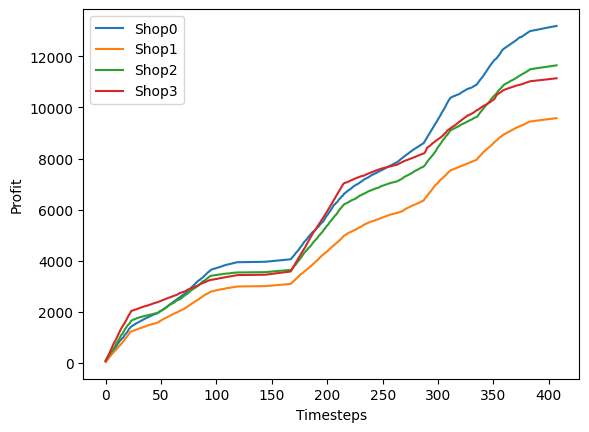

860397
obs= [7.76 8.11 7.5 ]  info= {'cost': 7.05, 'p0': 7.43, 'p1': 7.76, 'p2': 8.11, 'p3': 7.5, 's0': 42, 's1': 21, 's2': 16, 's3': 24}   reward= 15.959999999999996
obs= [7.76 8.11 7.46]  info= {'cost': 7.05, 'p0': 7.43, 'p1': 7.76, 'p2': 8.11, 'p3': 7.46, 's0': 50, 's1': 15, 's2': 13, 's3': 22}   reward= 18.999999999999993
obs= [7.76 8.11 7.46]  info= {'cost': 7.05, 'p0': 7.43, 'p1': 7.76, 'p2': 8.11, 'p3': 7.46, 's0': 45, 's1': 13, 's2': 16, 's3': 29}   reward= 17.099999999999994
obs= [7.76 8.11 7.46]  info= {'cost': 7.05, 'p0': 7.43, 'p1': 7.76, 'p2': 8.11, 'p3': 7.46, 's0': 51, 's1': 13, 's2': 16, 's3': 21}   reward= 19.379999999999995
obs= [7.76 8.11 7.46]  info= {'cost': 7.05, 'p0': 7.43, 'p1': 7.76, 'p2': 8.11, 'p3': 7.46, 's0': 49, 's1': 18, 's2': 14, 's3': 24}   reward= 18.619999999999994
obs= [7.76 8.11 7.46]  info= {'cost': 7.05, 'p0': 7.43, 'p1': 7.76, 'p2': 8.11, 'p3': 7.46, 's0': 44, 's1': 19, 's2': 19, 's3': 20}   reward= 16.719999999999995
obs= [7.76 8.11 7.46]  info=

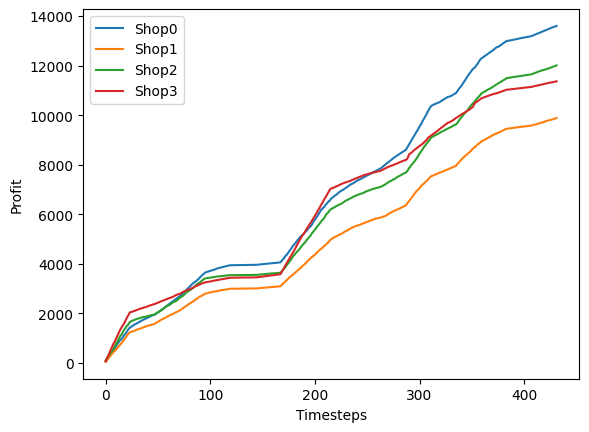

9195648702
obs= [2.57 2.69 2.49]  info= {'cost': 2.34, 'p0': 2.48, 'p1': 2.57, 'p2': 2.69, 'p3': 2.49, 's0': 46, 's1': 13, 's2': 11, 's3': 24}   reward= 6.440000000000006
obs= [2.57 2.69 2.48]  info= {'cost': 2.34, 'p0': 2.48, 'p1': 2.57, 'p2': 2.69, 'p3': 2.48, 's0': 35, 's1': 16, 's2': 14, 's3': 24}   reward= 4.900000000000004
obs= [2.57 2.69 2.48]  info= {'cost': 2.34, 'p0': 2.48, 'p1': 2.57, 'p2': 2.69, 'p3': 2.48, 's0': 34, 's1': 17, 's2': 18, 's3': 23}   reward= 4.760000000000004
obs= [2.57 2.69 2.48]  info= {'cost': 2.34, 'p0': 2.48, 'p1': 2.57, 'p2': 2.69, 'p3': 2.48, 's0': 33, 's1': 15, 's2': 7, 's3': 28}   reward= 4.6200000000000045
obs= [2.57 2.69 2.48]  info= {'cost': 2.34, 'p0': 2.48, 'p1': 2.57, 'p2': 2.69, 'p3': 2.48, 's0': 39, 's1': 6, 's2': 21, 's3': 18}   reward= 5.460000000000004
obs= [2.57 2.69 2.48]  info= {'cost': 2.34, 'p0': 2.48, 'p1': 2.57, 'p2': 2.69, 'p3': 2.48, 's0': 41, 's1': 13, 's2': 11, 's3': 18}   reward= 5.7400000000000055
obs= [2.57 2.69 2.48]  info= 

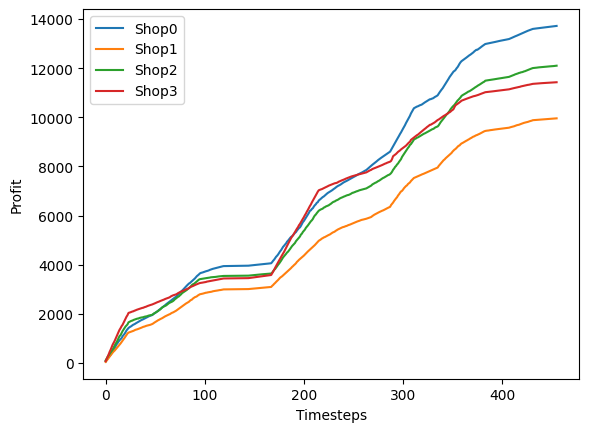

883598
obs= [8.04 8.41 7.78]  info= {'cost': 7.31, 'p0': 7.7, 'p1': 8.04, 'p2': 8.41, 'p3': 7.78, 's0': 34, 's1': 14, 's2': 15, 's3': 19}   reward= 13.26000000000002
obs= [8.04 8.41 7.73]  info= {'cost': 7.31, 'p0': 7.7, 'p1': 8.04, 'p2': 8.41, 'p3': 7.73, 's0': 30, 's1': 15, 's2': 11, 's3': 17}   reward= 11.700000000000017
obs= [8.04 8.41 7.73]  info= {'cost': 7.31, 'p0': 7.7, 'p1': 8.04, 'p2': 8.41, 'p3': 7.73, 's0': 36, 's1': 11, 's2': 10, 's3': 19}   reward= 14.04000000000002
obs= [8.04 8.41 7.73]  info= {'cost': 7.31, 'p0': 7.7, 'p1': 8.04, 'p2': 8.41, 'p3': 7.73, 's0': 31, 's1': 14, 's2': 8, 's3': 28}   reward= 12.090000000000018
obs= [8.04 8.41 7.73]  info= {'cost': 7.31, 'p0': 7.7, 'p1': 8.04, 'p2': 8.41, 'p3': 7.73, 's0': 31, 's1': 12, 's2': 6, 's3': 19}   reward= 12.090000000000018
obs= [8.04 8.41 7.73]  info= {'cost': 7.31, 'p0': 7.7, 'p1': 8.04, 'p2': 8.41, 'p3': 7.73, 's0': 38, 's1': 14, 's2': 4, 's3': 16}   reward= 14.820000000000022
obs= [8.04 8.41 7.73]  info= {'cost': 

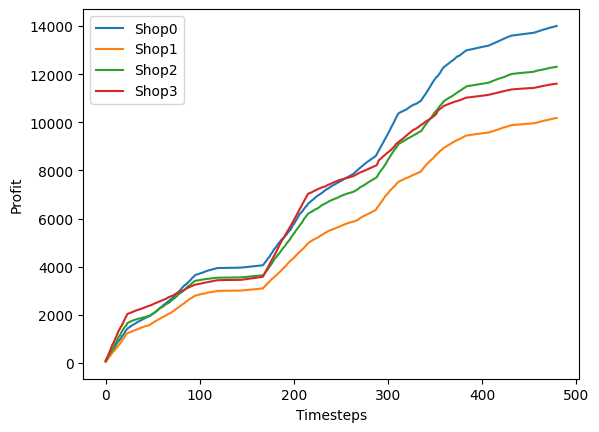

880181
obs= [13.98 14.62 14.66]  info= {'cost': 12.71, 'p0': 13.9, 'p1': 13.98, 'p2': 14.62, 'p3': 14.66, 's0': 13, 's1': 11, 's2': 4, 's3': 4}   reward= 15.469999999999994
obs= [13.98 14.62 14.73]  info= {'cost': 12.71, 'p0': 13.9, 'p1': 13.98, 'p2': 14.62, 'p3': 14.73, 's0': 23, 's1': 11, 's2': 2, 's3': 2}   reward= 27.36999999999999
obs= [13.98 14.62 14.73]  info= {'cost': 12.71, 'p0': 13.9, 'p1': 13.98, 'p2': 14.62, 'p3': 14.73, 's0': 21, 's1': 11, 's2': 5, 's3': 3}   reward= 24.989999999999988
obs= [13.98 14.62 14.88]  info= {'cost': 12.71, 'p0': 15.17, 'p1': 13.98, 'p2': 14.62, 'p3': 14.88, 's0': 0, 's1': 14, 's2': 6, 's3': 4}   reward= 0.0
obs= [13.98 14.62 14.73]  info= {'cost': 12.71, 'p0': 13.9, 'p1': 13.98, 'p2': 14.62, 'p3': 14.73, 's0': 17, 's1': 5, 's2': 6, 's3': 6}   reward= 20.22999999999999
obs= [13.98 14.62 14.73]  info= {'cost': 12.71, 'p0': 13.9, 'p1': 13.98, 'p2': 14.62, 'p3': 14.73, 's0': 16, 's1': 7, 's2': 8, 's3': 2}   reward= 19.039999999999992
obs= [13.98 14.6

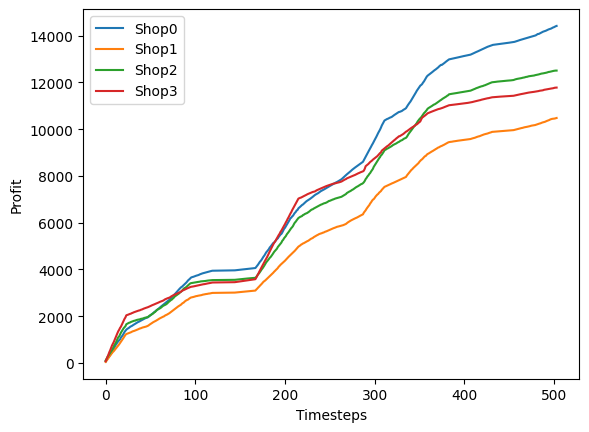

878408
obs= [8.3  8.68 8.03]  info= {'cost': 7.55, 'p0': 7.95, 'p1': 8.3, 'p2': 8.68, 'p3': 8.03, 's0': 56, 's1': 25, 's2': 10, 's3': 21}   reward= 22.40000000000002
obs= [8.3  8.68 7.98]  info= {'cost': 7.55, 'p0': 7.95, 'p1': 8.3, 'p2': 8.68, 'p3': 7.98, 's0': 50, 's1': 13, 's2': 18, 's3': 22}   reward= 20.000000000000018
obs= [8.3  8.68 7.98]  info= {'cost': 7.55, 'p0': 7.95, 'p1': 8.3, 'p2': 8.68, 'p3': 7.98, 's0': 46, 's1': 10, 's2': 21, 's3': 24}   reward= 18.400000000000016
obs= [8.3  8.68 7.98]  info= {'cost': 7.55, 'p0': 7.95, 'p1': 8.3, 'p2': 8.68, 'p3': 7.98, 's0': 46, 's1': 20, 's2': 12, 's3': 24}   reward= 18.400000000000016
obs= [8.3  8.68 7.98]  info= {'cost': 7.55, 'p0': 7.95, 'p1': 8.3, 'p2': 8.68, 'p3': 7.98, 's0': 47, 's1': 21, 's2': 15, 's3': 20}   reward= 18.80000000000002
obs= [8.3  8.68 7.98]  info= {'cost': 7.55, 'p0': 7.95, 'p1': 8.3, 'p2': 8.68, 'p3': 7.98, 's0': 56, 's1': 21, 's2': 13, 's3': 16}   reward= 22.40000000000002
obs= [8.3  8.68 7.98]  info= {'cost'

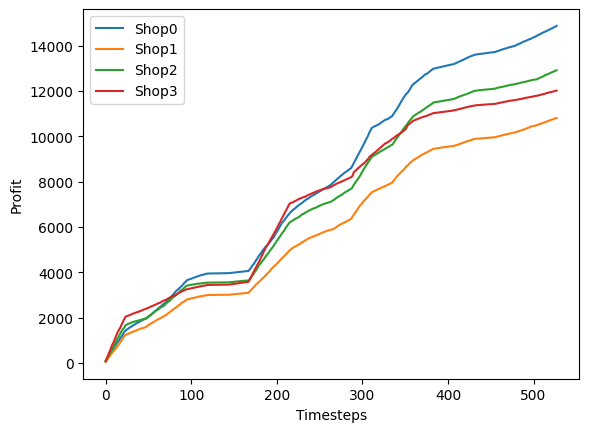

881912
obs= [7.88 8.23 7.62]  info= {'cost': 7.16, 'p0': 7.54, 'p1': 7.88, 'p2': 8.23, 'p3': 7.62, 's0': 48, 's1': 11, 's2': 18, 's3': 24}   reward= 18.239999999999995
obs= [7.88 8.23 7.57]  info= {'cost': 7.16, 'p0': 7.54, 'p1': 7.88, 'p2': 8.23, 'p3': 7.57, 's0': 52, 's1': 24, 's2': 16, 's3': 16}   reward= 19.759999999999994
obs= [7.88 8.23 7.57]  info= {'cost': 7.16, 'p0': 7.54, 'p1': 7.88, 'p2': 8.23, 'p3': 7.57, 's0': 43, 's1': 21, 's2': 11, 's3': 20}   reward= 16.339999999999996
obs= [7.88 8.23 7.57]  info= {'cost': 7.16, 'p0': 7.54, 'p1': 7.88, 'p2': 8.23, 'p3': 7.57, 's0': 40, 's1': 22, 's2': 16, 's3': 16}   reward= 15.199999999999996
obs= [7.88 8.23 7.57]  info= {'cost': 7.16, 'p0': 7.54, 'p1': 7.88, 'p2': 8.23, 'p3': 7.57, 's0': 43, 's1': 14, 's2': 18, 's3': 26}   reward= 16.339999999999996
obs= [7.88 8.23 7.57]  info= {'cost': 7.16, 'p0': 7.54, 'p1': 7.88, 'p2': 8.23, 'p3': 7.57, 's0': 64, 's1': 12, 's2': 10, 's3': 17}   reward= 24.319999999999993
obs= [7.88 8.23 7.57]  info

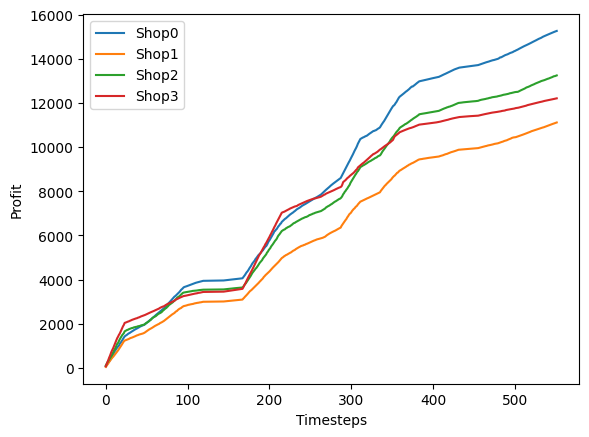

853997
obs= [14.34 15.   13.87]  info= {'cost': 13.04, 'p0': 13.74, 'p1': 14.34, 'p2': 15.0, 'p3': 13.87, 's0': 50, 's1': 18, 's2': 15, 's3': 23}   reward= 35.00000000000006
obs= [14.34 15.   13.79]  info= {'cost': 13.04, 'p0': 13.74, 'p1': 14.34, 'p2': 15.0, 'p3': 13.79, 's0': 45, 's1': 15, 's2': 12, 's3': 23}   reward= 31.50000000000005
obs= [14.34 15.   13.79]  info= {'cost': 13.04, 'p0': 13.74, 'p1': 14.34, 'p2': 15.0, 'p3': 13.79, 's0': 47, 's1': 20, 's2': 10, 's3': 27}   reward= 32.90000000000005
obs= [14.34 15.   13.79]  info= {'cost': 13.04, 'p0': 13.74, 'p1': 14.34, 'p2': 15.0, 'p3': 13.79, 's0': 52, 's1': 19, 's2': 8, 's3': 17}   reward= 36.400000000000055
obs= [14.34 15.   13.79]  info= {'cost': 13.04, 'p0': 13.74, 'p1': 14.34, 'p2': 15.0, 'p3': 13.79, 's0': 49, 's1': 16, 's2': 12, 's3': 21}   reward= 34.300000000000054
obs= [14.34 15.   13.79]  info= {'cost': 13.04, 'p0': 13.74, 'p1': 14.34, 'p2': 15.0, 'p3': 13.79, 's0': 48, 's1': 12, 's2': 11, 's3': 27}   reward= 33.60000

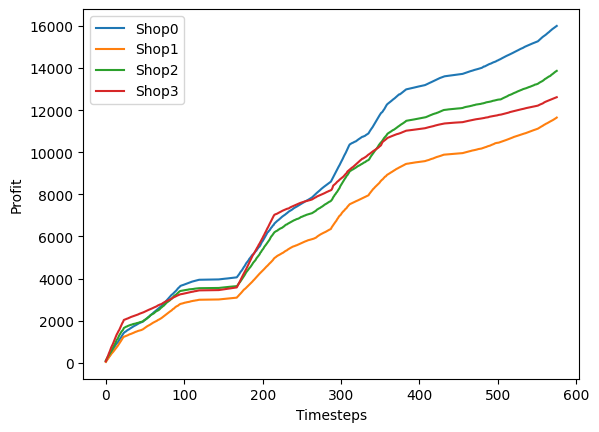

824836
obs= [17.08 17.86 17.74]  info= {'cost': 15.53, 'p0': 16.77, 'p1': 17.08, 'p2': 17.86, 'p3': 17.74, 's0': 19, 's1': 7, 's2': 7, 's3': 7}   reward= 23.560000000000002
obs= [17.08 17.86 17.58]  info= {'cost': 15.53, 'p0': 16.77, 'p1': 17.08, 'p2': 17.86, 'p3': 17.58, 's0': 17, 's1': 10, 's2': 4, 's3': 10}   reward= 21.080000000000005
obs= [17.08 17.86 17.58]  info= {'cost': 15.53, 'p0': 16.77, 'p1': 17.08, 'p2': 17.86, 'p3': 17.58, 's0': 21, 's1': 9, 's2': 4, 's3': 10}   reward= 26.040000000000006
obs= [17.08 17.86 17.58]  info= {'cost': 15.53, 'p0': 16.77, 'p1': 17.08, 'p2': 17.86, 'p3': 17.58, 's0': 23, 's1': 13, 's2': 8, 's3': 6}   reward= 28.520000000000003
obs= [17.08 17.86 17.58]  info= {'cost': 15.53, 'p0': 16.77, 'p1': 17.08, 'p2': 17.86, 'p3': 17.58, 's0': 17, 's1': 7, 's2': 2, 's3': 3}   reward= 21.080000000000005
obs= [17.08 17.86 17.58]  info= {'cost': 15.53, 'p0': 16.77, 'p1': 17.08, 'p2': 17.86, 'p3': 17.58, 's0': 20, 's1': 10, 's2': 3, 's3': 4}   reward= 24.80000000

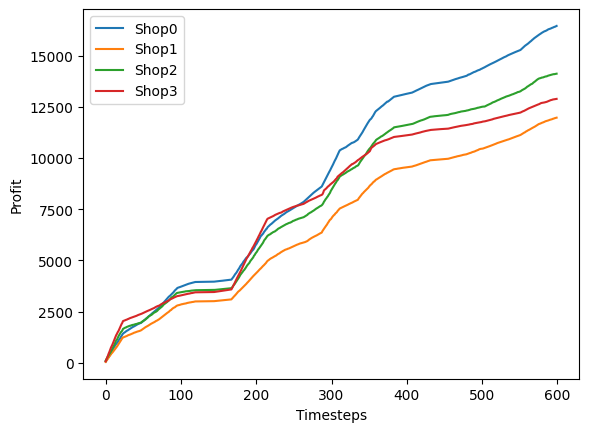

906355
obs= [4.98 5.21 4.82]  info= {'cost': 4.53, 'p0': 4.77, 'p1': 4.98, 'p2': 5.21, 'p3': 4.82, 's0': 45, 's1': 23, 's2': 22, 's3': 18}   reward= 10.799999999999969
obs= [4.98 5.21 4.79]  info= {'cost': 4.53, 'p0': 4.77, 'p1': 4.98, 'p2': 5.21, 'p3': 4.79, 's0': 50, 's1': 22, 's2': 13, 's3': 21}   reward= 11.999999999999966
obs= [4.98 5.21 4.79]  info= {'cost': 4.53, 'p0': 4.77, 'p1': 4.98, 'p2': 5.21, 'p3': 4.79, 's0': 58, 's1': 25, 's2': 13, 's3': 14}   reward= 13.91999999999996
obs= [4.98 5.21 4.79]  info= {'cost': 4.53, 'p0': 4.77, 'p1': 4.98, 'p2': 5.21, 'p3': 4.79, 's0': 51, 's1': 19, 's2': 16, 's3': 22}   reward= 12.239999999999966
obs= [4.98 5.21 4.79]  info= {'cost': 4.53, 'p0': 4.77, 'p1': 4.98, 'p2': 5.21, 'p3': 4.79, 's0': 48, 's1': 18, 's2': 22, 's3': 23}   reward= 11.519999999999968
obs= [4.98 5.21 4.79]  info= {'cost': 4.53, 'p0': 4.77, 'p1': 4.98, 'p2': 5.21, 'p3': 4.79, 's0': 49, 's1': 22, 's2': 14, 's3': 18}   reward= 11.759999999999966
obs= [4.98 5.21 4.79]  info=

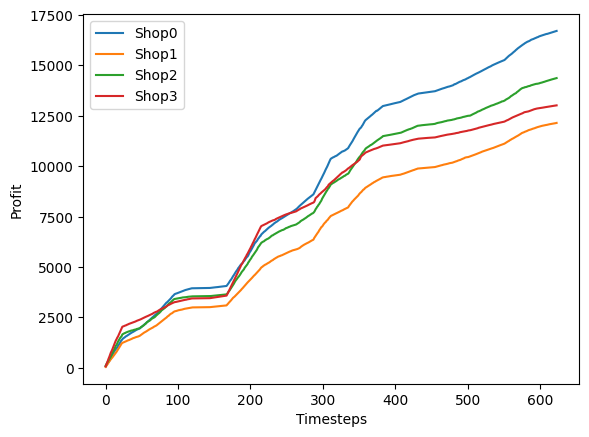

915813
obs= [19.45 20.33 21.58]  info= {'cost': 17.68, 'p0': 19.33, 'p1': 19.45, 'p2': 20.33, 'p3': 21.58, 's0': 16, 's1': 10, 's2': 8, 's3': 3}   reward= 26.399999999999977
obs= [19.45 20.33 21.48]  info= {'cost': 17.68, 'p0': 19.33, 'p1': 19.45, 'p2': 20.33, 'p3': 21.48, 's0': 13, 's1': 7, 's2': 7, 's3': 2}   reward= 21.44999999999998
obs= [19.45 20.33 21.48]  info= {'cost': 17.68, 'p0': 19.33, 'p1': 19.45, 'p2': 20.33, 'p3': 21.48, 's0': 19, 's1': 12, 's2': 14, 's3': 1}   reward= 31.349999999999973
obs= [19.45 20.33 21.48]  info= {'cost': 17.68, 'p0': 19.33, 'p1': 19.45, 'p2': 20.33, 'p3': 21.48, 's0': 17, 's1': 5, 's2': 6, 's3': 1}   reward= 28.049999999999976
obs= [19.45 20.33 21.48]  info= {'cost': 17.68, 'p0': 19.33, 'p1': 19.45, 'p2': 20.33, 'p3': 21.48, 's0': 22, 's1': 9, 's2': 4, 's3': 3}   reward= 36.29999999999997
obs= [19.45 20.33 21.48]  info= {'cost': 17.68, 'p0': 19.33, 'p1': 19.45, 'p2': 20.33, 'p3': 21.48, 's0': 14, 's1': 8, 's2': 2, 's3': 0}   reward= 23.099999999999

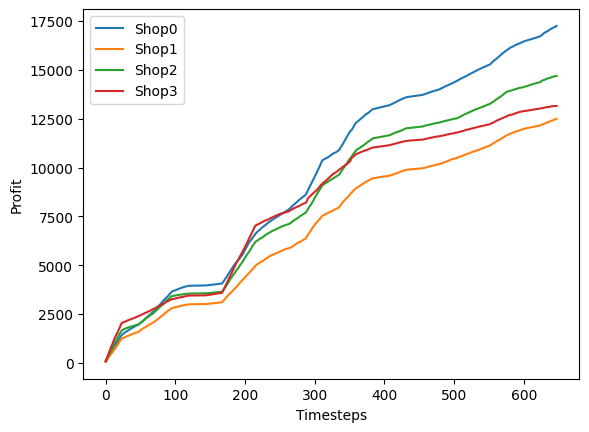

868410
obs= [19.29 20.17 18.66]  info= {'cost': 17.54, 'p0': 20.81, 'p1': 19.29, 'p2': 20.17, 'p3': 18.66, 's0': 18, 's1': 24, 's2': 16, 's3': 48}   reward= 58.85999999999999
obs= [19.29 20.17 18.88]  info= {'cost': 17.54, 'p0': 20.81, 'p1': 19.29, 'p2': 20.17, 'p3': 18.88, 's0': 15, 's1': 16, 's2': 23, 's3': 47}   reward= 49.05
obs= [19.29 20.17 18.88]  info= {'cost': 17.54, 'p0': 20.81, 'p1': 19.29, 'p2': 20.17, 'p3': 18.88, 's0': 13, 's1': 25, 's2': 15, 's3': 47}   reward= 42.50999999999999
obs= [19.29 20.17 18.88]  info= {'cost': 17.54, 'p0': 20.81, 'p1': 19.29, 'p2': 20.17, 'p3': 18.88, 's0': 12, 's1': 24, 's2': 19, 's3': 48}   reward= 39.239999999999995
obs= [19.29 20.17 18.88]  info= {'cost': 17.54, 'p0': 20.81, 'p1': 19.29, 'p2': 20.17, 'p3': 18.88, 's0': 12, 's1': 21, 's2': 24, 's3': 43}   reward= 39.239999999999995
obs= [19.29 20.17 18.43]  info= {'cost': 17.54, 'p0': 18.12, 'p1': 19.29, 'p2': 20.17, 'p3': 18.43, 's0': 45, 's1': 28, 's2': 15, 's3': 23}   reward= 26.1000000000

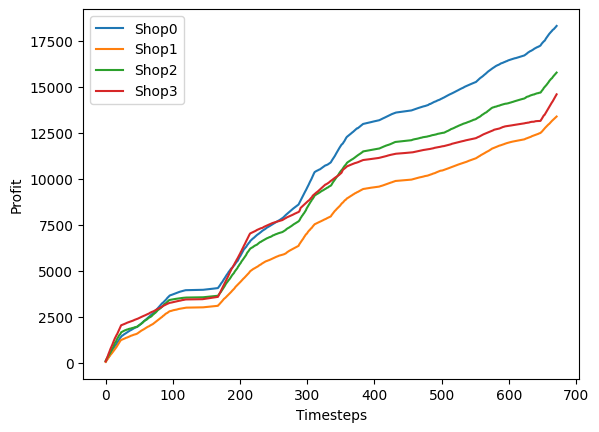

843456
obs= [6.61 6.91 6.39]  info= {'cost': 6.01, 'p0': 6.33, 'p1': 6.61, 'p2': 6.91, 'p3': 6.39, 's0': 50, 's1': 19, 's2': 12, 's3': 28}   reward= 16.000000000000014
obs= [6.61 6.91 6.35]  info= {'cost': 6.01, 'p0': 6.33, 'p1': 6.61, 'p2': 6.91, 'p3': 6.35, 's0': 43, 's1': 14, 's2': 19, 's3': 25}   reward= 13.760000000000012
obs= [6.61 6.91 6.26]  info= {'cost': 6.01, 'p0': 6.05, 'p1': 6.61, 'p2': 6.91, 'p3': 6.26, 's0': 54, 's1': 18, 's2': 13, 's3': 22}   reward= 2.160000000000002
obs= [6.61 6.91 6.35]  info= {'cost': 6.01, 'p0': 6.33, 'p1': 6.61, 'p2': 6.91, 'p3': 6.35, 's0': 52, 's1': 14, 's2': 16, 's3': 26}   reward= 16.640000000000015
obs= [6.61 6.91 6.35]  info= {'cost': 6.01, 'p0': 6.33, 'p1': 6.61, 'p2': 6.91, 'p3': 6.35, 's0': 46, 's1': 18, 's2': 13, 's3': 26}   reward= 14.720000000000013
obs= [6.61 6.91 6.35]  info= {'cost': 6.01, 'p0': 6.33, 'p1': 6.61, 'p2': 6.91, 'p3': 6.35, 's0': 43, 's1': 25, 's2': 15, 's3': 22}   reward= 13.760000000000012
obs= [6.61 6.91 6.35]  info=

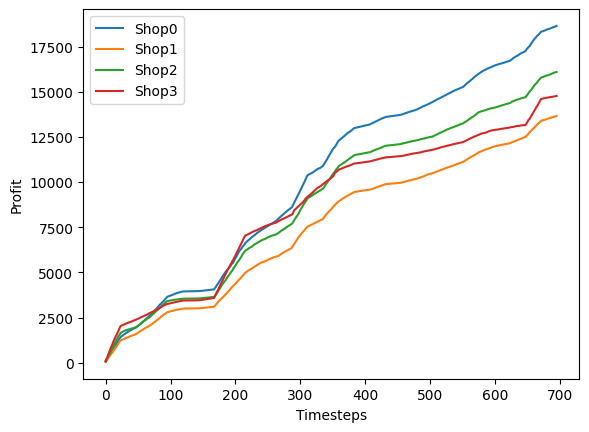

9197386536
obs= [1.4  1.46 1.41]  info= {'cost': 1.27, 'p0': 1.4, 'p1': 1.4, 'p2': 1.46, 'p3': 1.41, 's0': 8, 's1': 8, 's2': 10, 's3': 10}   reward= 1.0399999999999991
obs= [1.4  1.46 1.42]  info= {'cost': 1.27, 'p0': 1.39, 'p1': 1.4, 'p2': 1.46, 'p3': 1.42, 's0': 15, 's1': 8, 's2': 2, 's3': 12}   reward= 1.7999999999999983
obs= [1.4  1.46 1.42]  info= {'cost': 1.27, 'p0': 1.39, 'p1': 1.4, 'p2': 1.46, 'p3': 1.42, 's0': 17, 's1': 6, 's2': 3, 's3': 9}   reward= 2.0399999999999983
obs= [1.4  1.46 1.42]  info= {'cost': 1.27, 'p0': 1.39, 'p1': 1.4, 'p2': 1.46, 'p3': 1.42, 's0': 12, 's1': 12, 's2': 5, 's3': 8}   reward= 1.4399999999999986
obs= [1.4  1.46 1.42]  info= {'cost': 1.27, 'p0': 1.39, 'p1': 1.4, 'p2': 1.46, 'p3': 1.42, 's0': 16, 's1': 15, 's2': 4, 's3': 9}   reward= 1.9199999999999982
obs= [1.4  1.46 1.42]  info= {'cost': 1.27, 'p0': 1.39, 'p1': 1.4, 'p2': 1.46, 'p3': 1.42, 's0': 20, 's1': 6, 's2': 2, 's3': 7}   reward= 2.3999999999999977
obs= [1.4  1.46 1.42]  info= {'cost': 1.27, 

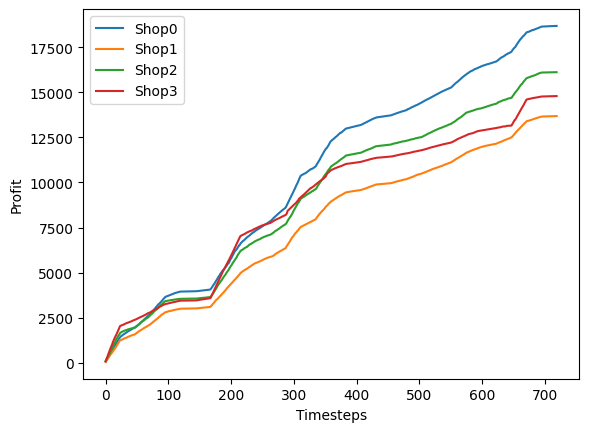

912893
obs= [12.02 12.57 11.63]  info= {'cost': 10.93, 'p0': 11.51, 'p1': 12.02, 'p2': 12.57, 'p3': 11.63, 's0': 55, 's1': 13, 's2': 16, 's3': 24}   reward= 31.900000000000006
obs= [12.02 12.57 11.55]  info= {'cost': 10.93, 'p0': 11.51, 'p1': 12.02, 'p2': 12.57, 'p3': 11.55, 's0': 48, 's1': 17, 's2': 14, 's3': 24}   reward= 27.840000000000003
obs= [12.02 12.57 11.55]  info= {'cost': 10.93, 'p0': 11.51, 'p1': 12.02, 'p2': 12.57, 'p3': 11.55, 's0': 48, 's1': 17, 's2': 16, 's3': 26}   reward= 27.840000000000003
obs= [12.02 12.57 11.55]  info= {'cost': 10.93, 'p0': 11.51, 'p1': 12.02, 'p2': 12.57, 'p3': 11.55, 's0': 54, 's1': 17, 's2': 12, 's3': 23}   reward= 31.320000000000004
obs= [12.02 12.57 11.55]  info= {'cost': 10.93, 'p0': 11.51, 'p1': 12.02, 'p2': 12.57, 'p3': 11.55, 's0': 54, 's1': 16, 's2': 15, 's3': 21}   reward= 31.320000000000004
obs= [12.02 12.57 11.55]  info= {'cost': 10.93, 'p0': 11.51, 'p1': 12.02, 'p2': 12.57, 'p3': 11.55, 's0': 60, 's1': 16, 's2': 11, 's3': 23}   reward

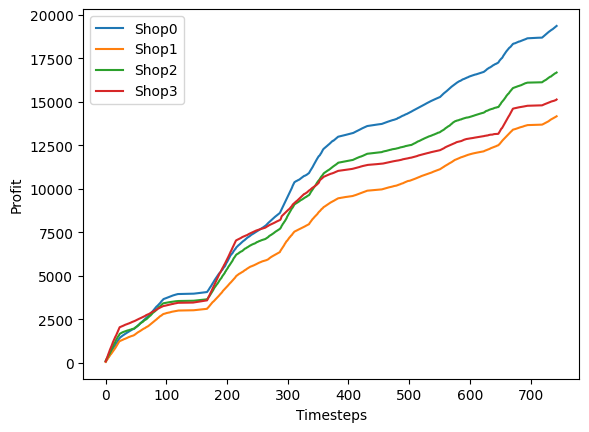

843257
obs= [19.26 20.14 18.63]  info= {'cost': 17.51, 'p0': 18.44, 'p1': 19.26, 'p2': 20.14, 'p3': 18.63, 's0': 53, 's1': 20, 's2': 12, 's3': 17}   reward= 49.289999999999985
obs= [19.26 20.14 18.51]  info= {'cost': 17.51, 'p0': 18.44, 'p1': 19.26, 'p2': 20.14, 'p3': 18.51, 's0': 51, 's1': 15, 's2': 15, 's3': 20}   reward= 47.429999999999986
obs= [19.26 20.14 18.51]  info= {'cost': 17.51, 'p0': 18.44, 'p1': 19.26, 'p2': 20.14, 'p3': 18.51, 's0': 41, 's1': 28, 's2': 19, 's3': 16}   reward= 38.12999999999999
obs= [19.26 20.14 18.51]  info= {'cost': 17.51, 'p0': 18.44, 'p1': 19.26, 'p2': 20.14, 'p3': 18.51, 's0': 48, 's1': 17, 's2': 10, 's3': 22}   reward= 44.639999999999986
obs= [19.26 20.14 18.51]  info= {'cost': 17.51, 'p0': 18.44, 'p1': 19.26, 'p2': 20.14, 'p3': 18.51, 's0': 48, 's1': 19, 's2': 16, 's3': 20}   reward= 44.639999999999986
obs= [19.26 20.14 18.51]  info= {'cost': 17.51, 'p0': 18.44, 'p1': 19.26, 'p2': 20.14, 'p3': 18.51, 's0': 46, 's1': 17, 's2': 16, 's3': 23}   reward=

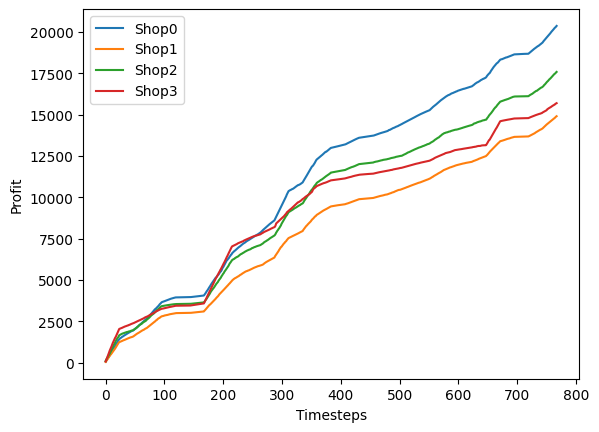

914571


FileNotFoundError: ignored

In [38]:
profits=pd.DataFrame(columns=['Shop0','Shop1','Shop2','Shop3'])
dff=pd.DataFrame(columns=['Shop0','Shop1','Shop2','Shop3'])
for i in sorted.SKU[0:40]:
  df=data.item(i)
  print(i)
  model=DQN.load('/content/drive/MyDrive/Thesis/Code/Models/'+'Model1_'+str(i))
  env = market_gym.CustomEnv(df,5000)
  episodes = 1
  for episode in range(1, episodes+1):
    obs,_states= env.reset()
    terminated=False
    while not terminated:
          action, _states = model.predict(obs)
          obs, reward, terminated,turnicated, info = env.step(action)
          #env.render()
          new_row={'Shop0':(info['p0']-info['cost'])*info['s0'],'Shop1':(info['p1']-info['cost'])*info['s1'],'Shop2':(info['p2']-info['cost'])*info['s2'],'Shop3':(info['p3']-info['cost'])*info['s3']}
          profits=pd.concat([profits, pd.DataFrame([new_row])], ignore_index=True)
          print('obs=', obs,' info=',info ,'  reward=', reward)
    ax=profits.cumsum().plot()
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("Profit")
    plt.show()
    dff.loc[i]=profits.sum()
  del model

In [37]:
dff.sum()

Shop0    158843.64
Shop1    121091.04
Shop2    139638.81
Shop3    141216.68
dtype: float64